# Importing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math
import sklearn
import pprint
import scipy
from sklearn.datasets.samples_generator import make_blobs, make_moons, make_circles
from collections import OrderedDict, Counter
from copy import deepcopy
import graphviz
from IPython.display import display

In [2]:
from pyclustering.cluster.birch import birch, measurement_type
from pyclustering.cluster import cluster_visualizer

In [3]:
import hdbscan
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import SpectralClustering, KMeans, AgglomerativeClustering, Birch
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib.patches import Rectangle
import networkx as nx
from mpl_toolkits.mplot3d import Axes3D 
from scipy import ndimage

In [4]:
# import jtplot module in notebook
from jupyterthemes import jtplot
#! jt -t oceans16 -tf merriserif -tfs 10 -nf ptsans -nfs 13 -T -N -kl -m 90

# choose which theme to inherit plotting style from
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
#jtplot.style(theme='monokai')
#jtplot.style(ticks=True, grid=False)
jtplot.reset()

In [5]:
import warnings
warnings.filterwarnings("ignore") 

# Generating Dataset

In [29]:
# generate 2d classification dataset
X, y = make_blobs(n_samples=80, centers=4, n_features=2, cluster_std=1.8, random_state=42)

# scatter plot, dots colored by class value
#df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
#colors = {0:'red', 1:'blue', 2:'green', 3:'yellow'}
#fig, ax = plt.subplots(figsize=(12,4))
#grouped = df.groupby('label')
#for key, group in grouped:
#    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key], s=50, edgecolor="black")
#plt.show()

In [6]:
# generate 2d classification dataset
X, y = make_moons(n_samples=80, noise=0.05, random_state=42)

# scatter plot, dots colored by class value
#df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
#colors = {0:'red', 1:'blue', 2:'green', 3:'yellow'}
#fig, ax = plt.subplots(figsize=(12,4))
#grouped = df.groupby('label')
#for key, group in grouped:
#    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key], s=50, edgecolor="black")
#plt.show()

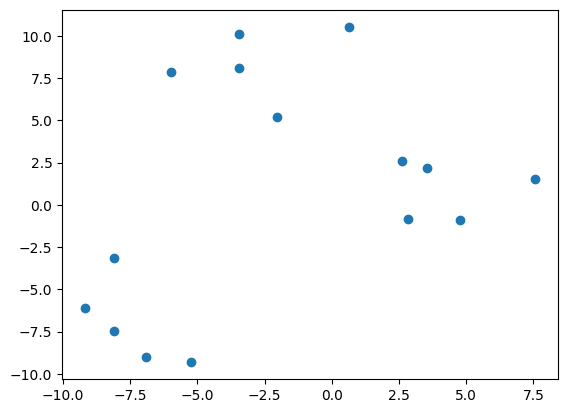

In [91]:
varied = make_blobs(n_samples=15,
                             cluster_std=[2.0, 2.0, 2.0],
                             random_state=42)[0]
plt.scatter(varied[:,0], varied[:,1])
#plt.gcf().gca().add_artist(plt.Circle((-5, 0), 5, color="red", fill=False, linewidth=3, alpha=0.7))
plt.show()

# OPTICS

Cluster analysis method based on the OPTICS algorithm. OPTICS computes an augmented cluster-ordering of the database objects. The main advantage of our approach, when compared to the clustering algorithms proposed in the literature, is that we do not limit ourselves to one global parameter setting. Instead, the augmented cluster-ordering contains information which is equivalent to the density-based clusterings corresponding to a broad range of parameter settings and thus is a versatile basis for both automatic and interactive cluster analysis.

## Functions

In [17]:
def point_plot(X_dict, x,y, eps, processed=None, col='yellow'):
    
    fig, ax = plt.subplots(figsize=(14,6))
    
    plt.scatter(X[:,0], X[:,1], s=300, color="lime", edgecolor="black")
    
    if processed is not None:
        for i in processed:
            plt.scatter(X_dict[i][0],X_dict[i][1], color=col, s=300 )
    
    plt.scatter(x=x,y=y,s=400, color="black", alpha=0.4)
    
    circle1 = plt.Circle((x, y), eps, color='r', fill=False, linewidth=3, alpha=0.7)
    plt.gcf().gca().add_artist(circle1)
    
    xmin, xmax, ymin, ymax = plt.axis()
    xwidth = xmax - xmin
    ywidth = ymax - ymin
    
    xw1 = xwidth*0.008
    yw1 = ywidth*0.01
    
    xw2 = xwidth*0.005
    yw2 = ywidth*0.01

    for i, txt in enumerate([i for i in range(len(X))]):
        if len(str(txt))==2:
            ax.annotate(txt, (X[:,0][i]-xw1, X[:,1][i]-yw1), fontsize=12, size=12)
        else:
            ax.annotate(txt, (X[:,0][i]-xw2, X[:,1][i]-yw2), fontsize=12, size=12)
    
    plt.show()

In [18]:
#point_plot(dict(zip([str(i) for i in range(len(X))], X)), X[0,0], X[0,1], eps=0.3)

In [19]:
# original euclidean distance
def dist1(x,y):   
    return np.sqrt(np.sum((x-y)**2))

In [20]:
# euclidean distance which takes keys of a dictionary (X_dict) as inputs
def dist2(data, x,y):   
    return np.sqrt(np.sum((data[x]-data[y])**2))

In [21]:
# neighborhood search for a point of a given dataset-dictionary (data) with a fixed eps
def scan_neigh1(data, point, eps):
    
    neigh = {}
    distances = {}
    
    for i, element in enumerate(data.values()):
        
        d = dist1(element, point)
        
        if (d <= eps) and (d != 0):
            
            neigh.update({str(i):element})

    return neigh   


In [22]:
# variation that returns only the keys of the input dictionary with the euclidean distances <= eps from the point
def scan_neigh2(data, point, eps):
    
    neigh = {}
    distances = {}
    
    for i, element in enumerate(data.values()):
        
        d = dist1(element, point)
        
        if (d <= eps) and (d != 0):
            
            distances.update({str(i):d})

    d_sorted = sorted(distances.items(), key=lambda x: x[1], reverse=False)

    return d_sorted

In [23]:
# returns the minPTS-distance of a point if it is a core point, else it return np.inf
def minPTSdist(data, o, minPTS, eps):
    
    S = scan_neigh2(data, data[o], eps)
    
    if len(S) >= minPTS-1:
        
        return S[minPTS-2][1]
    
    else:
        
        return np.inf    

In [24]:
#reachability distance (even if it is not a distance because it isn't symmetrical)
def reach_dist(data, x,y, minPTS, eps):
    
    return max(dist2(data, x,y), minPTSdist(data, y, minPTS, eps))

In [25]:
# plots the reachability plot, along with a horizontal line denoting eps, from the ClustDist produced by OPTICS
def Reach_plot(data, ClustDist, eps):
    plot_dic = {}

    for key, value in ClustDist.items():
        
        if np.isinf(value) == True:
            
            plot_dic[key] = eps*1.15
        
        else:
            
            plot_dic[key] = ClustDist[key]
        
    missing_keys = list(set(data.keys())-set(ClustDist.keys()))
    
    tick_list = list(ClustDist.keys()) + [' ']*(len(missing_keys))

    for m_k in missing_keys:

        plot_dic[m_k] = 0
        
    fig, ax = plt.subplots(1, 1, figsize=(12,5))
    
    ax.bar(plot_dic.keys(),plot_dic.values())
    
    ax.set_xticks(tick_list)
    
    ax.axhline(eps, color="red", linewidth=3)
    
    ax1 = ax.twinx()
    ax1.set_ylim(ax.get_ylim())
    ax1.set_yticks([eps])
    ax1.set_yticklabels(["\u03B5"])

    plt.show()

In [26]:
def OPTICS(X, eps, minPTS, plot=True, plot_reach=False):
    
    ClustDist = {}
    CoreDist = {}
    Seed =  {}
    processed = []
    
    # create dictionary
    X_dict = dict(zip([str(i) for i in range(len(X))], X))

    while len(processed) != len(X):

        if len(Seed) == 0:

                unprocessed = list(set(list(X_dict.keys())) - set(processed))

                (o, r) = (random.choice(unprocessed), np.inf)

        else:

            (o, r) = (min(Seed, key=Seed.get), Seed[min(Seed, key=Seed.get)])

            del Seed[o]

        N = scan_neigh1(X_dict, X_dict[o], eps)

        ClustDist.update({o:r})
        
        CoreDist.update({o: minPTSdist(X_dict, o, minPTS, eps)})
        
        if plot == True:
            
            point_plot(X_dict, X_dict[o][0], X_dict[o][1], eps, processed)
            
            if plot_reach == True:
                
                Reach_plot(X_dict, ClustDist, eps)
        

        processed.append(o)

        if len(N) >= minPTS-1 :

            for n in N:

                if n in processed:

                    continue

                else:

                    p = reach_dist(X_dict, n, o, minPTS, eps)

                    if n in Seed:

                        if p < Seed[n]:

                            Seed[n] = p
                    else:

                        Seed.update({n:p})
    
    return (ClustDist, CoreDist)

In [27]:
#extracts cluster in a DBSCAN fashion; one can use any eps_db <= eps of OPTICS
def ExtractDBSCANclust(ClustDist, CoreDist, eps_db):
    
    Clust_Dict = {}
    
    noise = -1
    
    clust_id = -1
    
    for key, value in ClustDist.items():
        
        if value > eps_db:
            
            if CoreDist[key] <= eps_db:
                
                clust_id += 1
                
                Clust_Dict[key] = clust_id
                
            else:
                
                Clust_Dict[key] = noise
                
        else:
            
            Clust_Dict[key] = clust_id
    
    return Clust_Dict

In [28]:
def plot_clust(X, ClustDist, CoreDist, eps, eps_db):
    
    X_dict = dict(zip([str(i) for i in range(len(X))], X))

    cl = ExtractDBSCANclust(ClustDist, CoreDist, eps_db)

    new_dict = {key: (val1, cl[key]) for key,val1 in zip(list(X_dict.keys()),list(X_dict.values())) }

    new_dict = OrderedDict((k, new_dict[k]) for k in list(ClustDist.keys()))

    df = pd.DataFrame(dict(x = [i[0][0] for i in list(new_dict.values())], 
                 y=[i[0][1] for i in list(new_dict.values())], 
                 label= [i[1]for i in list(new_dict.values())]), index=new_dict.keys())

    colors = {-1:'red', 0:'lightblue', 1:'beige', 2:'yellow', 3:'grey', 
              4:'pink', 5:'navy', 6:'orange', 7:'purple', 8:'salmon', 9:'olive', 10:'brown',
             11:'tan', 12: 'lime'}

    #fig, ax = plt.subplots(figsize=(14,6))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))
    
    grouped = df.groupby('label')
    for key, group in grouped:
        group.plot(ax=ax1, kind='scatter', x='x', y='y', label=key, color=colors[key], s=300, edgecolor="black")

    ax1.set_xlabel("")
    ax1.set_ylabel("")
    
    xmin, xmax, ymin, ymax = ax1.axis()
    xwidth = xmax - xmin
    ywidth = ymax - ymin

    xw1 = xwidth*0.01
    yw1 = ywidth*0.01
    
    xw2 = xwidth*0.003
    yw2 = ywidth*0.01

    for i, txt in enumerate([i for i in range(len(X))]):
        if len(str(txt))==2:
            ax1.annotate(txt, (X[:,0][i]-xw1, X[:,1][i]-yw1), fontsize=8, size=10)
        else:
            ax1.annotate(txt, (X[:,0][i]-xw2, X[:,1][i]-yw2), fontsize=8, size=10)


    #plt.show()

    plot_dic = {}

    for key, value in ClustDist.items():

        if np.isinf(value) == True:

            plot_dic[key] = eps*1.15

        else:

            plot_dic[key] = ClustDist[key]

    #plt.figure(figsize=(8,5), ax=ax)
    #fig, ax = plt.subplots(figsize=(8,5))
    ax2.bar(plot_dic.keys(),plot_dic.values(), color=[colors[i] for i in df.label], edgecolor="black")

    ax2.axhline(eps, color="black", linewidth=3)

    #plt.annotate("\u03B5", (0.920,0.79), xycoords='figure fraction')

    ax2.axhline(eps_db, color="black", linewidth=3)

    #plt.annotate("\u03B5"+"\'", (438,eps_db*103), xycoords='axes points')
    
    ax3 = ax2.twinx()
    ax3.set_ylim(ax2.get_ylim())
    ax3.set_yticks([eps, eps_db])
    ax3.set_yticklabels(["\u03B5", "\u03B5"+"\'"])

    plt.show()

## Testing

In [44]:
#ClustDist, CoreDist = OPTICS(X, eps=2, minPTS=3, plot=True, plot_reach=True)

In [22]:
#ClustDist, CoreDist = OPTICS(X, eps=0.5, minPTS=3, plot=False, plot_reach=False)

In [43]:
#plot_clust(X, ClustDist, CoreDist, eps=2, eps_db=1.3)

# DBSCAN

ADVANTAGES:

DBSCAN does not require one to specify the number of clusters in the data a priori, as opposed to k-means.

DBSCAN can find arbitrarily shaped clusters. It can even find a cluster completely surrounded by (but not connected to) a different cluster. Due to the MinPts parameter, the so-called single-link effect (different clusters being connected by a thin line of points) is reduced.

DBSCAN has a notion of noise, and is robust to outliers.

DBSCAN requires just two parameters and is mostly insensitive to the ordering of the points in the database. (However, points sitting on the edge of two different clusters might swap cluster membership if the ordering of the points is changed, and the cluster assignment is unique only up to isomorphism.)

DBSCAN is designed for use with databases that can accelerate region queries, e.g. using an R* tree.

The parameters minPts and ε can be set by a domain expert, if the data is well understood.

DISADVANTAGES:

DBSCAN is not entirely deterministic: border points that are reachable from more than one cluster can be part of either cluster, depending on the order the data are processed. For most data sets and domains, this situation does not arise often and has little impact on the clustering result: both on core points and noise points, DBSCAN is deterministic. DBSCAN* is a variation that treats border points as noise, and this way achieves a fully deterministic result as well as a more consistent statistical interpretation of density-connected components.

The quality of DBSCAN depends on the distance measure used in the function regionQuery(P,ε). The most common distance metric used is Euclidean distance. Especially for high-dimensional data, this metric can be rendered almost useless due to the so-called "Curse of dimensionality", making it difficult to find an appropriate value for ε. This effect, however, is also present in any other algorithm based on Euclidean distance.

DBSCAN cannot cluster data sets well with large differences in densities, since the minPts-ε combination cannot then be chosen appropriately for all clusters.

If the data and scale are not well understood, choosing a meaningful distance threshold ε can be difficult.

## Functions

In [19]:
# modification that takes also the point itself into account
def scan_neigh1_mod(data, point, eps):
    
    neigh = {}
    distances = {}
    
    for i, element in enumerate(data.values()):
        
        d = dist1(element, point)
        
        if (d <= eps):
            
            neigh.update({str(i):element})

    return neigh   

In [20]:
def point_plot_mod(X_dict, x,y, eps, ClustDict, clust_id):
    
    colors = {-1:'red', 0:'lightblue', 1:'beige', 2:'yellow', 3:'grey', 
              4:'pink', 5:'navy', 6:'orange', 7:'purple', 8:'salmon', 9:'olive', 10:'brown',
             11:'tan', 12: 'lime'}
    
    fig, ax = plt.subplots(figsize=(14,6))
    
    plt.scatter(X[:,0], X[:,1], s=300, color="lime", edgecolor="black")
    
    for i in ClustDict:
        plt.scatter(X_dict[i][0],X_dict[i][1], color=colors[ClustDict[i]], s=300 )
    
    plt.scatter(x=x,y=y,s=400, color="black", alpha=0.4)
    
    circle1 = plt.Circle((x, y), eps, color='r', fill=False, linewidth=3, alpha=0.7)
    plt.gcf().gca().add_artist(circle1)
    
    xmin, xmax, ymin, ymax = plt.axis()
    xwidth = xmax - xmin
    ywidth = ymax - ymin
    
    xw1 = xwidth*0.008
    yw1 = ywidth*0.01
    
    xw2 = xwidth*0.005
    yw2 = ywidth*0.01

    for i, txt in enumerate([i for i in range(len(X))]):
        if len(str(txt))==2:
            ax.annotate(txt, (X[:,0][i]-xw1, X[:,1][i]-yw1), fontsize=12, size=12)
        else:
            ax.annotate(txt, (X[:,0][i]-xw2, X[:,1][i]-yw2), fontsize=12, size=12)
    
    plt.show()

In [21]:
def plot_clust_DB(X, ClustDict, eps, circle_class=None, Noise_circle=True):

    X_dict = dict(zip([str(i) for i in range(len(X))], X))

    new_dict = {key: (val1, ClustDict[key]) for key,val1 in zip(list(X_dict.keys()),list(X_dict.values())) }

    new_dict = OrderedDict((k, new_dict[k]) for k in list(ClustDict.keys()))

    df = pd.DataFrame(dict(x = [i[0][0] for i in list(new_dict.values())], 
                 y=[i[0][1] for i in list(new_dict.values())], 
                 label= [i[1]for i in list(new_dict.values())]), index=new_dict.keys())

    colors = {-1:'red', 0:'lightblue', 1:'beige', 2:'yellow', 3:'grey', 
              4:'pink', 5:'navy', 6:'orange', 7:'purple', 8:'salmon', 9:'olive', 10:'brown',
             11:'tan', 12: 'lime'}

    #fig, ax = plt.subplots(figsize=(14,6))
    fig, ax1 = plt.subplots(1, 1, figsize=(18,6))

    grouped = df.groupby('label')

        #for key, group in grouped:

            #group.plot(ax=ax1, kind='scatter', x='x', y='y', label=key, color=colors[key], s=300, edgecolor="black")

    lista_lab = list(df.label.value_counts().index)
    
    for lab in lista_lab:

        df_sub = df[df.label == lab]
        plt.scatter(df_sub.x, df_sub.y, color = colors[lab], s=300, edgecolor="black")

    if Noise_circle == True:

        df_noise = df[df.label == -1]

        for i in range(len(df_noise)):
            
            ax1.add_artist(plt.Circle((df_noise["x"].iloc[i], 
                                       df_noise["y"].iloc[i]), eps, color='r', fill=False, linewidth=3, alpha=0.7))
            
    if circle_class is not None:
        
        if circle_class != "true":
            
            lista_lab = circle_class
        
        for lab in lista_lab:
        
            if lab != -1:
                
                df_temp = df[df.label == lab]
                
                for i in range(len(df_temp)):
            
                    ax1.add_artist(plt.Circle((df_temp["x"].iloc[i], df_temp["y"].iloc[i]), 
                                              eps, color=colors[lab], fill=False, linewidth=3, alpha=0.7))
                
    ax1.set_xlabel("")
    ax1.set_ylabel("")
    
    
    xmin, xmax, ymin, ymax = plt.axis()
    xwidth = xmax - xmin
    ywidth = ymax - ymin
    
    xw1 = xwidth*0.005
    yw1 = ywidth*0.01
    
    xw2 = xwidth*0.0025
    yw2 = ywidth*0.01

    for i, txt in enumerate([i for i in range(len(X))]):
        if len(str(txt))==2:
            ax1.annotate(txt, (X[:,0][i]-xw1, X[:,1][i]-yw1), fontsize=8, size=10)
        else:
            ax1.annotate(txt, (X[:,0][i]-xw2, X[:,1][i]-yw2), fontsize=8, size=10)


    plt.show()

In [22]:
def DBSCAN(data, eps, minPTS, plotting=False, print_details=False):
        
    ClustDict = {}

    clust_id = -1

    X_dict = dict(zip([str(i) for i in range(len(X))], X))

    processed = []

    processed_list = []

    #unprocessed = list(set(list(X_dict.keys())) - set(processed))

    for point in X_dict:

        if point not in processed:

            processed.append(point)

            #print(processed)

            N = scan_neigh1_mod(X_dict, X_dict[point], eps)
            
            if print_details == True:
                
                print("len(N): ", len(N))

            if len(N) < minPTS:

                ClustDict.update({point: -1})
                
                if plotting == True:
                    
                    point_plot_mod(X_dict, X_dict[point][0], X_dict[point][1], eps, ClustDict, -1)

            else:

                clust_id+=1

                ClustDict.update({point: clust_id})
                
                if plotting == True:
                
                    point_plot_mod(X_dict, X_dict[point][0], X_dict[point][1], eps, ClustDict, clust_id)

                processed_list = [point]
                
                del N[point]

                while len(N)>0:
                    
                    if print_details == True:
                    
                        print("len(N) in while loop: ", len(N))

                    n = random.choice(list(N.keys()))

                    while (n in processed_list):

                        n = random.choice(list(N.keys()))

                    processed_list.append(n)

                    del N[n]

                    if n not in processed:

                        processed.append(n)

                        N_2 = scan_neigh1_mod(X_dict, X_dict[n], eps)
                        
                        if print_details == True:
                        
                            print("len N2: ", len(N_2))

                        if len(N_2) >= minPTS:

                            for element in N_2:

                                if element not in processed_list:

                                    N.update({element: X_dict[element]})

                    if (n not in ClustDict) or (ClustDict[n] == -1):

                        ClustDict.update({n: clust_id})
                    
                    if plotting == True:
                            
                            point_plot_mod(X_dict, X_dict[n][0], X_dict[n][1], eps, ClustDict, clust_id)
                            
    return ClustDict

## Choosing eps

In [24]:
# we choose k as minPTS
k = 3
neigh = NearestNeighbors(n_neighbors=k)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
#plt.plot(distances)
#plt.xlabel("Points")
#plt.ylabel("Distances")
#plt.title("{0}-distance plot".format(k))
#plt.show()

#the best eps seems to be around 0.150, even if later we see that eps = 0.3 works better

## Testing

In [30]:
#ClustDict = DBSCAN(X, eps=0.3, minPTS=3, plotting=True)

In [31]:
#ClustDict = DBSCAN(X, eps=0.3, minPTS=3, plotting=False)

In [32]:
#plot_clust_DB(X, ClustDict, eps=0.3, Noise_circle=True, circle_class="true")

# HDBSCAN

https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html 

Density-based clustering is a popular clustering paradigm. However, the existing methods have a number of limitations: 

(i) Some methods (e.g., DBSCAN and DENCLUE ) can only provide a “flat” (i.e. non-hierarchical) labeling of the data objects, based on a global density threshold. Using a single density threshold can often not properly characterize common data sets with clusters of very different densities and/or nested clusters. 

(ii) Among the methods that provide a clustering hierarchy, some (e.g., gSkeletonClu) are not able to automatically simplify the hierarchy into an easily interpretable representation involving only the most significant clusters. 

(iii) Many hierarchical methods, including OPTICS and gSkeletonClu, suggest only how to extract a flat partition by using a global cut/density threshold, which may not result in the most significant clusters if these clusters are characterized by different density levels. 

(iv) Some methods are limited to specific classes of problems, such as networks (gSkeletonClu), and point sets in the real coordinate space (e.g., DECODE, and Generalized Single-Linkage). 

(v) Most methods depend on multiple, often critical input parameters.

In this paper, we propose a clustering approach that, to the best of our knowledge, is unique in that it does not suffer from any of these drawbacks. 
In detail, we make the following contributions: 

(i) We introduce a hierarchical clustering method, called HDBSCAN, which generates a complete density-based clustering hierarchy from which a simplified hierarchy composed only of the most significant clusters can be easily extracted. 

(ii) We propose a new measure of cluster stability for the purpose of extracting a set of significant clusters from possibly different levels of a simplified cluster tree produced by HDBSCAN. 

(iii) We formulate the task of extracting a set of significant clusters as an optimization problem in which the overall stability of the composing clusters is maximized. 

(iv) We propose an algorithm that finds the globally optimal solution to this problem. 

(v) We demonstrate the advancement in density-based clustering that our approach represents on a variety of real world data sets.

In [39]:
# by default min_samples is set equal to min_cluster_size
clusterer = hdbscan.HDBSCAN(min_cluster_size=3, gen_min_span_tree=True)
clusterer.fit(X)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_method='eom',
        core_dist_n_jobs=4, gen_min_span_tree=True, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=3, min_samples=None, p=None,
        prediction_data=False)

In [ ]:
plt.figure(figsize = (18,8))
clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                      edge_alpha=0.6,
                                      node_size=120,
                                      edge_linewidth=3,
                                      )

xmin, xmax, ymin, ymax = plt.axis()
xwidth = xmax - xmin
ywidth = ymax - ymin

xw1 = xwidth*0.015
yw1 = ywidth*0

xw2 = xwidth*0.01
yw2 = ywidth*0

for i, txt in enumerate([i for i in range(len(X))]):
    if len(str(txt))==2:
        plt.annotate(txt, (X[:,0][i]+xw1, X[:,1][i]-yw1), fontsize=12, size=12)
    else:
        plt.annotate(txt, (X[:,0][i]+xw2, X[:,1][i]-yw2), fontsize=12, size=12)


plt.show()

In [41]:
# distances in detail
dist_df = clusterer.minimum_spanning_tree_.to_pandas()
dist_df = dist_df.sort_values("distance", ascending=False)
dist_df
#they are processed in this order in the dendrogram below, starting from the whole data 
#and finishing with the single points
# in case of a tie in distances the splits must be executed simultaneously (as in 69 and 68 in the dist_df)

,from,to,distance
78,1,65,0.393793
77,1,69,0.289347
76,29,43,0.280570
75,31,51,0.272799
74,45,36,0.240618
...,...,...,...
4,30,18,0.129756
3,7,14,0.128782
2,15,56,0.126826
1,42,4,0.125325


In [ ]:
#the scale is in log2, it proceeds from the top to the bottom
plt.figure(figsize = (18,8))
clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)
plt.show()

In [43]:
#Each row of the dataframe corresponds to an edge in the tree. 
#The parent and child are the ids of the parent and child nodes in the tree. 
#Node ids less than the number of points in the original dataset represent individual points, 
#while ids greater than the number of points are clusters.

#The lambda_val value is the value (1/distance) at which the child node
#leaves the cluster (1/distance of previous dataframe)

#The child_size is the number of points in the child node.

clusterer.condensed_tree_.to_pandas()

,parent,child,lambda_val,child_size
0,80,81,2.539408,40
1,80,82,2.539408,40
2,81,1,3.456058,1
3,82,31,3.665699,1
4,81,29,3.564171,1
...,...,...,...,...
91,95,2,7.224528,1
92,95,57,7.224528,1
93,96,28,6.529639,1
94,96,42,6.529639,1


In [ ]:
plt.figure(figsize = (18,8))
clusterer.condensed_tree_.plot()
clust_data = clusterer.condensed_tree_.get_plot_data()["cluster_bounds"]

xmin, xmax, ymin, ymax = plt.axis()
xwidth = xmax - xmin
ywidth = ymax - ymin

for name in list(clust_data.keys()):
    data = clust_data[name]
    x = (data[0] + data[1])/2 -xwidth*0.01
    y = (data[3])-ywidth*0.04
    plt.annotate("{0}".format(name), (x,y), fontsize=15, size=15, color="black")

plt.show()

In [ ]:
plt.figure(figsize = (18,8))
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
clust_data = clusterer.condensed_tree_.get_plot_data()["cluster_bounds"]

xmin, xmax, ymin, ymax = plt.axis()
xwidth = xmax - xmin
ywidth = ymax - ymin

for name in list(clust_data.keys()):
    data = clust_data[name]
    x = (data[0] + data[1])/2 -xwidth*0.01
    y = (data[3])-ywidth*0.04
    plt.annotate("{0}".format(name), (x,y), fontsize=15, size=15)
plt.show()

In [33]:
#clusterer.labels_

In [34]:
#clusterer.probabilities_

In [35]:
#clusterer.outlier_scores_

In [ ]:
plt.figure(figsize=(18,8))
palette = sns.color_palette()
cluster_colors = [sns.desaturate(palette[col], sat)
                  if col >= 0 else (0.5, 0.5, 0.5) for col, sat in
                  zip(clusterer.labels_, clusterer.probabilities_)]
plt.scatter(X.T[0], X.T[1], c=cluster_colors, s=400, edgecolor="black")

xmin, xmax, ymin, ymax = plt.axis()
xwidth = xmax - xmin
ywidth = ymax - ymin

xw1 = xwidth*0.008
yw1 = ywidth*0.008

xw2 = xwidth*0.005
yw2 = ywidth*0.008

for i, txt in enumerate([i for i in range(len(X))]):
    if len(str(txt))==2:
        plt.annotate(txt, (X[:,0][i]-xw1, X[:,1][i]-yw1), fontsize=12, size=12)
    else:
        plt.annotate(txt, (X[:,0][i]-xw2, X[:,1][i]-yw2), fontsize=12, size=12)


plt.show()

# SPECTRAL CLUSTERING

## Initial Discussion

http://people.csail.mit.edu/dsontag/courses/ml14/notes/Luxburg07_tutorial_spectral_clustering.pdf

The ε-neighborhood graph: Here we connect all points whose pairwise distances are smaller than ε. As the distances between all connected points are roughly of the same scale (at most ε), weighting the edges would not incorporate more information about the data to the graph. Hence, the ε-neighborhood graph is usually considered as an unweighted graph.

k-nearest neighbor graphs: Here the goal is to connect vertex vi with vertex vj if vj is among the k-nearest neighbors of vi. However, this definition leads to a directed graph, as the neighborhood relationship is not symmetric. There are two ways of making this graph undirected. The first way is to simply ignore the directions of the edges, that is we connect vi and vj with an undirected edge if vi is among the k-nearest neighbors of vj or if vj is among the k-nearest neighbors of vi. The resulting graph is what is usually called the k-nearest neighbor graph. The second choice is to connect vertices vi and vj if both vi is among the k-nearest neighbors of vj and vj is among the k-nearest neighbors of vi. The resulting graph is called the mutual k-nearest neighbor graph. In both cases, after connecting the appropriate vertices we weight the edges by the similarity of their endpoints.

The fully connected graph: Here we simply connect all points with positive similarity with each other, and we weight all edges by sij. As the graph should represent the local neighborhood re- lationships, this construction is only useful if the similarity function itself models local neighbor- hoods. An example for such a similarity function is the Gaussian similarity function s(xi,xj) = exp(−||xi −xj||^2/(2σ^2)), where the parameter σ controls the width of the neighborhoods. This pa- rameter plays a similar role as the parameter ε in case of the ε-neighborhood graph.

The matrix L satisfies the following properties:
1. L is symmetric and positive semi-definite.
2. The smallest eigenvalue of L is 0, the corresponding eigenvector is the constant one vector . 
3. L has n non-negative, real-valued eigenvalues 0 = λ1 ≤ λ2 ≤ . . . ≤ λn .

Let G be an undirected graph with non-negative weights. Then the multiplicity k of the eigenvalue 0 of L equals the number of connected components A1, . . . , Ak in the graph. The eigenspace of eigenvalue 0 is spanned by the indicator vectors   A1 , . . . ,   Ak of those components.

$$L_{sym} := D^{−1/2} L D^{−1/2} = I − D^{−1/2} W D^{−1/2}$$

$$L_{rw} :=D^{−1} L = I − D^{−1} W. $$

The normalized Laplacians satisfy the following properties:
1. λ is an eigenvalue of L_rw with eigenvector u if and only if λ is an eigenvalue of L_sym with eigenvector w = D^1/2u.
2. λ is an eigenvalue of L_rw with eigenvector u if and only if λ and u solve the generalized eigenproblem Lu = λDu.
3. 0 is an eigenvalue of L_rw with the constant one vector as eigenvector. 0 is an eigenvalue of L_sym with eigenvector D^1/2 .
4. L_sym and L_rw are positive semi-definite and have n non-negative real-valued eigenvalues 0 = λ1 ≤...≤ λn.

Let G be an undirected graph with non-negative weights. Then the multiplicity k of the eigenvalue 0 of both L_rw and L_sym equals the number of connected components A1 , . . . , Ak in the graph. For L_rw , the eigenspace of 0 is spanned by the indicator vectors 1_Ai of those components. For L_sym, the eigenspace of 0 is spanned by the vectors D^1/2 1_Ai .

In [35]:
float_formatter = lambda x: "%.3f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})
sns.set()

In [ ]:
X = np.array([
    [1, 3], [2, 1], [1, 1],
    [3, 2], [7, 8], [9, 8],
    [9, 9], [8, 7], [13, 14],
    [14, 14], [15, 16], [14, 15]
])
plt.figure(figsize=(10,3))
plt.scatter(X[:,0], X[:,1], alpha=0.7, edgecolors='b', s=250)
plt.xlabel('Weight')
plt.ylabel('Height')
plt.show()

In [38]:
W = pairwise_distances(X, metric="euclidean")
vectorizer = np.vectorize(lambda x: 1 if x < 5 else 0)
W = np.vectorize(vectorizer)(W)
print(W)

[[1 1 1 1 0 0 0 0 0 0 0 0]
 [1 1 1 1 0 0 0 0 0 0 0 0]
 [1 1 1 1 0 0 0 0 0 0 0 0]
 [1 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 1 1 0 0 0 0]
 [0 0 0 0 1 1 1 1 0 0 0 0]
 [0 0 0 0 1 1 1 1 0 0 0 0]
 [0 0 0 0 1 1 1 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 1 1 1 1]]


In [39]:
def draw_graph(G):
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos)
    nx.draw_networkx_labels(G, pos)
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
    plt.show()

## First Example

GRAPH with a single connected component. We will observe a single null eigenvalue; the fact that the second smallest eigenvalue is big indicates that there is a single cluster

In [ ]:
G = nx.random_graphs.erdos_renyi_graph(10, 0.5)
draw_graph(G)
W = nx.adjacency_matrix(G)
print(W.todense())

In [44]:
# degree matrix
D = np.diag(np.sum(np.array(W.todense()), axis=1))
print('degree matrix:')
print(D)
# Laplacian matrix
L = D - W
print('laplacian matrix:')
print(L)

degree matrix:
[[8 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 4 0 0 0 0 0 0]
 [0 0 0 0 4 0 0 0 0 0]
 [0 0 0 0 0 4 0 0 0 0]
 [0 0 0 0 0 0 8 0 0 0]
 [0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 0 5 0]
 [0 0 0 0 0 0 0 0 0 5]]
laplacian matrix:
[[ 8 -1 -1 -1  0 -1 -1 -1 -1 -1]
 [-1  4  0  0 -1  0  0 -1  0 -1]
 [-1  0  7 -1 -1 -1 -1 -1  0 -1]
 [-1  0 -1  4  0  0 -1  0  0 -1]
 [ 0 -1 -1  0  4  0 -1  0 -1  0]
 [-1  0 -1  0  0  4 -1  0 -1  0]
 [-1  0 -1 -1 -1 -1  8 -1 -1 -1]
 [-1 -1 -1  0  0  0 -1  5 -1  0]
 [-1  0  0  0 -1 -1 -1 -1  5  0]
 [-1 -1 -1 -1  0  0 -1  0  0  5]]


In [45]:
e, v = np.linalg.eig(L)
# eigenvalues
print('eigenvalues:')
print(e)
# eigenvectors
print('eigenvectors:')
print(v)

eigenvalues:
[0.000 9.325 8.950 8.398 3.126 3.229 4.228 4.817 6.043 5.882]
eigenvectors:
[[0.316 0.664 -0.568 -0.319 0.072 0.046 0.152 0.025 -0.060 0.012]
 [0.316 -0.202 0.033 -0.105 -0.133 -0.641 0.365 -0.332 -0.260 -0.327]
 [0.316 -0.226 0.267 -0.728 0.101 0.084 -0.087 -0.003 0.471 0.032]
 [0.316 0.019 0.155 0.143 0.670 0.074 -0.292 0.185 -0.249 -0.468]
 [0.316 0.216 0.028 0.192 -0.421 -0.266 -0.724 -0.104 0.177 -0.037]
 [0.316 0.053 0.150 0.241 -0.187 0.625 0.210 -0.542 0.079 -0.217]
 [0.316 -0.623 -0.662 0.174 0.023 0.111 -0.076 0.079 0.088 0.105]
 [0.316 0.112 0.179 0.342 -0.158 -0.090 0.411 0.604 0.404 -0.092]
 [0.316 -0.098 0.221 -0.185 -0.358 0.241 -0.036 0.341 -0.660 0.260]
 [0.316 0.085 0.196 0.246 0.391 -0.184 0.079 -0.253 0.010 0.733]]


In [ ]:
fig = plt.figure(figsize=(12,3))
ax1 = plt.subplot(121)
plt.plot(e)
ax1.title.set_text('eigenvalues')
i = np.where(e < 10e-6)[0] #very low #1st column
ax2 = plt.subplot(122)
plt.plot(v[:, i[0]])
fig.tight_layout()
plt.show()

## Second Example

GRAPH with two cluster. We will observe two null eigenvalues, so two clusters, since the third eigenvalue is pretty high

In [ ]:
G = nx.Graph()
G.add_edges_from([
    [1, 2], [1, 3], [1, 4], [2, 3], [2, 7], [3, 4], [4, 7], [1, 7],
    [6, 5], [5, 8], [6, 8], [9, 8], [9, 6]
])
draw_graph(G)
W = nx.adjacency_matrix(G)
#print(W.todense())

In [48]:
# degree matrix
D = np.diag(np.sum(np.array(W.todense()), axis=1))
#print('degree matrix:')
#print(D)
# laplacian matrix
L = D - W
#print('laplacian matrix:')
#print(L)
e, v = np.linalg.eig(L)
# eigenvalues
print('eigenvalues:')
print(e)
# eigenvectors
print('eigenvectors:')
print(v)

eigenvalues:
[5.000 0.000 5.000 3.000 3.000 4.000 0.000 4.000 2.000]
eigenvectors:
[[0.894 -0.447 0.077 0.000 0.000 0.000 0.000 0.000 0.000]
 [-0.224 -0.447 0.479 0.707 0.392 0.000 0.000 0.000 0.000]
 [-0.224 -0.447 -0.517 -0.000 -0.588 0.000 0.000 0.000 0.000]
 [-0.224 -0.447 0.479 -0.707 -0.392 0.000 0.000 0.000 0.000]
 [-0.224 -0.447 -0.517 0.000 0.588 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.866 -0.500 -0.154 0.000]
 [0.000 0.000 0.000 0.000 0.000 -0.289 -0.500 -0.350 -0.707]
 [0.000 0.000 0.000 0.000 0.000 -0.289 -0.500 0.855 -0.000]
 [0.000 0.000 0.000 0.000 0.000 -0.289 -0.500 -0.350 0.707]]


In [ ]:
fig = plt.figure(figsize=[18, 3])
ax1 = plt.subplot(131)
plt.plot(e)
ax1.title.set_text('eigenvalues')
i = np.where(e < 10e-6)[0] #(array([1, 6]),)
ax2 = plt.subplot(132)
plt.plot(v[:, i[0]]) #2nd column
ax2.title.set_text('first eigenvector with eigenvalue of 0')
ax3 = plt.subplot(133)
plt.plot(v[:, i[1]]) #7th column
ax3.title.set_text('second eigenvector with eigenvalue of 0')
plt.show()

In [ ]:
new_mat = np.concatenate([v[:, i[0]], v[:, i[1]]], axis=1)

plt.scatter(np.array(new_mat.T[0])[0], np.array(new_mat.T[1])[0], alpha=0.5, s=400)
plt.show()

km = KMeans(init='k-means++', n_clusters=2)
km.fit(new_mat)
print(km.labels_)

Alternative way with $ L_{sym} $

In [51]:
D_pow = scipy.linalg.fractional_matrix_power(D,-0.5)

L_norm = np.matmul(np.matmul(D_pow, L), D_pow)

In [52]:
e, v = np.linalg.eig(L_norm)
# eigenvalues
print('eigenvalues:')
print(e)
# eigenvectors
print('eigenvectors:')
print(v)

eigenvalues:
[1.333 0.000 1.000 1.667 1.000 -0.000 1.333 1.667 1.000]
eigenvectors:
[[0.866 -0.500 0.000 -0.000 0.000 0.000 0.000 0.000 0.000]
 [-0.250 -0.433 -0.707 0.500 -0.333 0.000 0.000 0.000 0.000]
 [-0.250 -0.433 -0.000 -0.500 -0.624 0.000 0.000 0.000 0.000]
 [-0.250 -0.433 0.707 0.500 0.333 0.000 0.000 0.000 0.000]
 [-0.250 -0.433 -0.000 -0.500 0.624 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.548 0.707 -0.447 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.447 -0.000 0.548 -0.707]
 [0.000 0.000 0.000 0.000 0.000 0.548 -0.707 -0.447 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.447 0.000 0.548 0.707]]


In [53]:
i = np.where(e < 10e-6)[0] #(array([1, 6]),)
print(i)
new_mat = np.concatenate([v[:, i[0]], v[:, i[1]]], axis=1)

[1 5]


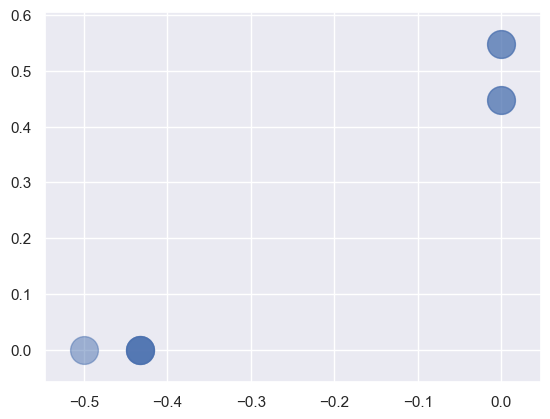

In [54]:
plt.scatter(np.array(new_mat.T[0])[0], np.array(new_mat.T[1])[0], alpha=0.5, s=400)
plt.show()

In [55]:
km = KMeans(init='k-means++', n_clusters=2)
km.fit(new_mat)
km.labels_

array([0, 0, 0, 0, 0, 1, 1, 1, 1], dtype=int32)

## Third Example

GRAPH with only one connected component, but with two visible clusters; we will observe a null eigenvalue, but the second and third smallest are also close to zero, so one can choose k=2 or k=3

In [ ]:
G = nx.Graph()
G.add_edges_from([
    [1, 2], [1, 3], [1, 4], [2, 3],
    [3, 4], [4, 5], [1, 5], [6, 7],
    [7, 8], [6, 8], [6, 9], [9, 6], [7, 10], [7, 2]
])
draw_graph(G)
W = nx.adjacency_matrix(G)
print(W.todense())

In [64]:
D = np.diag(np.sum(np.array(W.todense()), axis=1))
L = D - W
e, v = np.linalg.eig(L)
# eigenvalues
print('eigenvalues:')
print(e)
# eigenvectors
print('eigenvectors:')
print(v)

eigenvalues:
[5.485 4.898 4.398 3.801 3.155 -0.000 0.229 0.728 1.913 1.393]
eigenvectors:
[[-0.430 0.773 -0.021 0.068 -0.049 -0.316 -0.320 -0.047 -0.078 0.011]
 [0.478 -0.014 0.232 0.123 -0.532 -0.316 -0.154 0.054 -0.525 -0.130]
 [-0.092 -0.345 -0.592 0.021 0.378 -0.316 -0.303 -0.032 -0.430 -0.033]
 [0.181 -0.104 0.616 -0.207 0.522 -0.316 -0.364 -0.078 0.136 0.066]
 [0.071 -0.231 -0.248 0.077 -0.410 -0.316 -0.387 -0.099 0.656 0.127]
 [0.240 0.203 -0.244 -0.744 -0.028 -0.316 0.338 -0.164 0.083 -0.199]
 [-0.666 -0.401 0.288 -0.187 -0.246 -0.316 0.196 0.201 -0.062 -0.187]
 [0.122 0.068 -0.018 0.517 0.238 -0.316 0.301 0.029 0.244 -0.636]
 [-0.054 -0.052 0.072 0.266 0.013 -0.316 0.438 -0.603 -0.091 0.505]
 [0.148 0.103 -0.085 0.067 0.114 -0.316 0.254 0.739 0.068 0.476]]


In [ ]:
fig = plt.figure(figsize=[18, 3])
ax1 = plt.subplot(131)
plt.plot(e)
ax1.title.set_text('eigenvalues')
i = np.where(e < 0.8)[0]
ax2 = plt.subplot(132)
plt.plot(v[:, i[0]])
ax3 = plt.subplot(133)
plt.plot(v[:, i[1]])
ax3.title.set_text('second eigenvector with eigenvalue close to 0')
plt.show()

In [ ]:
new_mat = np.concatenate([v[:, i[0]], v[:, i[1]]], axis=1)

plt.scatter(np.array(new_mat.T[0])[0], np.array(new_mat.T[1])[0], alpha=0.5, s=400)
plt.show()

km = KMeans(init='k-means++', n_clusters=2)
km.fit(new_mat)
print(km.labels_)

In [ ]:
new_mat = np.concatenate([v[:, i[0]], v[:, i[1]], v[:,i[2]]], axis=1)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(np.array(new_mat.T[0])[0], np.array(new_mat.T[1])[0],np.array(new_mat.T[2])[0], alpha=0.5, s=400)
plt.show()

km = KMeans(init='k-means++', n_clusters=3, random_state=42)
km.fit(new_mat)
print(km.labels_)

## Fourth Example

GRAPH with one single connected component, but with 3 or 4 visible clusters, therefore we try with k=3 and k=4 

In [ ]:
G = nx.Graph()
G.add_edges_from([
    [1, 2], [1, 3], [1, 4], [2, 3], [3, 4], [4, 5],
    [1, 5], [6, 7], [7, 8], [6, 8], [6, 9], [9, 6],
    [7, 10], [7, 2], [11, 12], [12, 13], [7, 12],
    [11, 13]
])

draw_graph(G)
W = nx.adjacency_matrix(G)
#print(W.todense())

In [77]:
D = np.diag(np.sum(np.array(W.todense()), axis=1))
L = D - W
e, v = np.linalg.eig(L)
# eigenvalues
print('eigenvalues:')
print(e)
# eigenvectors
print('eigenvectors:')
print(v)

eigenvalues:
[6.333 5.020 4.471 3.862 3.535 3.138 1.915 -0.000 0.184 0.348 0.772 1.421
 3.000]
eigenvectors:
[[0.136 -0.867 0.086 -0.015 0.092 0.040 -0.079 -0.277 0.347 0.078 0.040
  -0.009 -0.000]
 [-0.312 0.253 0.318 -0.023 0.299 0.482 -0.527 -0.277 0.205 0.014 -0.054
  0.127 -0.000]
 [0.070 0.189 -0.667 -0.008 -0.073 -0.355 -0.434 -0.277 0.333 0.071 0.025
  0.035 0.000]
 [-0.056 0.231 0.577 0.044 -0.352 -0.473 0.135 -0.277 0.384 0.096 0.069
  -0.062 -0.000]
 [-0.018 0.211 -0.269 -0.016 0.169 0.380 0.661 -0.277 0.403 0.106 0.089
  -0.124 -0.000]
 [-0.220 -0.077 -0.087 0.795 -0.122 0.025 0.077 -0.277 -0.152 -0.355
  0.113 0.214 0.000]
 [0.834 0.166 0.114 0.042 -0.179 0.248 -0.058 -0.277 -0.102 -0.113 -0.185
  0.174 -0.000]
 [-0.142 -0.029 -0.011 -0.450 0.196 -0.240 0.226 -0.277 -0.140 -0.284
  -0.059 0.670 0.000]
 [0.041 0.019 0.025 -0.278 0.048 -0.012 -0.084 -0.277 -0.187 -0.545 0.495
  -0.507 -0.000]
 [-0.156 -0.041 -0.033 -0.015 0.071 -0.116 0.063 -0.277 -0.125 -0.174
  -0.810 -0.4

In [ ]:
fig = plt.figure(figsize=[15, 6])
ax1 = plt.subplot(221)
plt.plot(e)
ax1.title.set_text('eigenvalues')
i = np.where(e < 0.8)[0]
ax2 = plt.subplot(222)
plt.plot(v[:, i[0]])
ax3 = plt.subplot(223)
plt.plot(v[:, i[1]])
ax3.title.set_text('second eigenvector with eigenvalue close to 0')
ax4 = plt.subplot(224)
plt.plot(v[:, i[2]])
ax4.title.set_text('third eigenvector with eigenvalue close to 0')
fig.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(3,3))
draw_graph(G)

In [ ]:
new_mat = np.concatenate([v[:, i[0]], v[:, i[1]], v[:,i[2]]], axis=1)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(np.array(new_mat.T[0])[0], np.array(new_mat.T[1])[0],np.array(new_mat.T[2])[0], alpha=0.5, s=400)
plt.show()

km = KMeans(init='k-means++', n_clusters=3, random_state=42)
km.fit(new_mat)
print(km.labels_)

In [85]:
new_mat = np.concatenate([v[:, i[0]], v[:, i[1]], v[:,i[2]], v[:,i[3]]], axis=1)

#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
#ax.scatter(np.array(new_mat.T[0])[0], np.array(new_mat.T[1])[0],np.array(new_mat.T[2])[0], alpha=0.5, s=400)
#plt.show()

km = KMeans(init='k-means++', n_clusters=4, random_state=42)
km.fit(new_mat)
print(km.labels_)

[0 0 0 0 0 1 1 1 1 2 3 3 3]


In [ ]:
X, clusters = make_circles(n_samples=1000, noise=.06, factor=.5, random_state=0)

sc = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', random_state=42)
sc_clustering = sc.fit(X)
plt.scatter(X[:,0], X[:,1], c=sc_clustering.labels_, cmap='rainbow', alpha=0.7, edgecolors='b')

# HIERARCHICAL AGGLOMERATIVE CLUSTERING

## Function update_mat and testing

In [20]:
def update_mat(mat,i,j, linkage):
    
    a1 = mat.iloc[i]
    b1 = mat.iloc[j]
    
    if linkage == "single":
        
        vec = [np.min([p,q]) for p,q in zip(a1.values,b1.values)]
        vec[i] = np.inf
        vec[j] = np.inf
    
    elif linkage == "complete":
        
        vec = [np.max([p,q]) for p,q in zip(a1.values,b1.values)]
    
    elif linkage == "average":
        
        l_a1 = len(a1.name.replace("(","").replace(")","").split("-"))
        l_b1 = len(b1.name.replace("(","").replace(")","").split("-"))
        vec = [(l_a1*a1[k]+l_b1*b1[k])/(l_a1+l_b1) for k in range(len(a1))]
        #vec = [np.mean([p,q]) for p,q in zip(a1.values,b1.values)]

    mat.loc["("+a1.name+")"+"-"+"("+b1.name+")",:] = vec
    mat["("+a1.name+")"+"-"+"("+b1.name+")"] = vec + [np.inf]
    
    mat = mat.drop([a1.name,b1.name], 0)
    mat = mat.drop([a1.name,b1.name], 1)
    
    return mat    

In [21]:
def prova_update_mat(mat, linkage, steps):
    for _ in range(steps):
        (i, j) = np.unravel_index(np.array(mat).argmin(), np.array(mat).shape)
        mat = update_mat(mat,i,j, linkage)
    return mat

### Testing

In [43]:
provaX = pd.DataFrame({"0":[np.inf,1,5,2], "1":[1,np.inf,3,4], "2":[5,3,np.inf,1], "3":[2,4,1,np.inf]}, 
                      index=[str(i) for i in range(4)])

In [44]:
provaX

,0,1,2,3
0,inf,1.0,5.0,2.0
1,1.0,inf,3.0,4.0
2,5.0,3.0,inf,1.0
3,2.0,4.0,1.0,inf


In [45]:
(i, j) = np.unravel_index(np.array(provaX).argmin(), np.array(provaX).shape)
(i,j)

(0, 1)

In [46]:
bum = update_mat(provaX,i,j,"average")
bum

,2,3,(0)-(1)
2,inf,1.0,4.0
3,1.0,inf,3.0
(0)-(1),4.0,3.0,inf


In [47]:
bam = update_mat(bum,i,j, "average")
bam

,(0)-(1),(2)-(3)
(0)-(1),inf,3.5
(2)-(3),3.5,inf


In [48]:
(i, j) = np.unravel_index(np.array(bam).argmin(), np.array(bam).shape)
(i,j)

(0, 1)

In [49]:
bim = update_mat(bam,i,j, "average")
bim

,((0)-(1))-((2)-(3))
((0)-(1))-((2)-(3)),inf


## Functions

In [25]:
#X #80
X, y = make_moons(n_samples=80, noise=0.05, random_state=42)

In [26]:
def point_plot_mod(X, a, level_txt, level2_txt=None):
    
    fig, ax = plt.subplots(figsize=(14,6))
    
    plt.scatter(X[:,0], X[:,1], s=300, color="lime", edgecolor="black")
    
    a = a.dropna(1, how="all")
    
    colors = { 0:"seagreen", 1:'beige', 2:'yellow', 3:'grey', 
              4:'pink', 5:'navy', 6:'orange', 7:'purple', 8:'salmon', 9:'olive', 10:'brown',
             11:'tan', 12: 'plum', 13:'red', 14:'lightblue', 15:"khaki", 16:"gainsboro", 17:"peachpuff"}
    
    len_ind = [len(i.split("-")) for i in list(a.index)]
    start = np.min([i for i in range(len(len_ind)) if len_ind[i]>1])
    
    for ind,i in enumerate(range(start,len(a))):
        point = a.iloc[i].name.replace("(","").replace(")","").split("-")
        point = [int(i) for i in point]
        for j in range(len(point)):
            plt.scatter(X[point[j],0], X[point[j],1], s=350, color=colors[ind%14])
                
    point = a.iloc[-1].name.replace("(","").replace(")","").split("-")
    point = [int(i) for i in point]
    com = X[point].mean(axis=0)
    rect_min = X[point].min(axis=0)
    rect_diff = X[point].max(axis=0)-rect_min
    
    xmin, xmax, ymin, ymax = plt.axis()
    xwidth = xmax - xmin
    ywidth = ymax - ymin
    
    plt.gcf().gca().add_patch(Rectangle((rect_min[0] - .05, rect_min[1] - .05), 
                                        rect_diff[0]+.1, rect_diff[1]+.1, fill=True, 
                                        color=colors[ind%14], alpha=0.3, linewidth=3, 
                                        ec="black"))
    plt.gcf().gca().add_patch(Rectangle((rect_min[0] - .05, rect_min[1] - .05), 
                                        rect_diff[0]+.1, rect_diff[1]+.1, fill=None, 
                                        color='r', alpha=1, linewidth=3 
                                        ))
    
    xmin, xmax, ymin, ymax = plt.axis()
    xwidth = xmax - xmin
    ywidth = ymax - ymin
    
    xw1 = xwidth*0.008
    yw1 = ywidth*0.01
    
    xw2 = xwidth*0.005
    yw2 = ywidth*0.01

    for i, txt in enumerate([i for i in range(len(X))]):
        if len(str(txt))==2:
            ax.annotate(txt, (X[:,0][i]-xw1, X[:,1][i]-yw1), fontsize=12, size=12)
        else:
            ax.annotate(txt, (X[:,0][i]-xw2, X[:,1][i]-yw2), fontsize=12, size=12)
            
    ax.annotate("dist_tot: " + str(round(level_txt,5)), (xmax*0.75,ymax*0.9), fontsize=12, size=12)
    
    if level2_txt is not None:
        ax.annotate("dist_incr: " + str(round(level2_txt,5)), (xmax*0.75,ymax*0.8), fontsize=12, size=12)
    
    ax.annotate("n° clust: " + str(len(a)), (xmax*0.75,ymax*0.7), fontsize=12, size=12)
    
    plt.show()

In [27]:
def dist_mat(mat, linkage):
    
    even_num = [i for i in range(2,len(X)+1) if i%2==0]
    D = pd.DataFrame()
    ind = list(mat.index)
    k = 0
    for i in ind:
        for j in ind[k:]:
            if i!=j:
                
                a = mat.loc[i].values
                b = mat.loc[j].values
                z1 = [i for i in even_num if i<=len(a)]
                z2 = [i for i in even_num if i<=len(b)]
                a = [a[:z1[0]]]+[a[z1[i]:z1[i+1]] for i in range(len(z1)-1)]
                b = [b[:z2[0]]]+[b[z2[i]:z2[i+1]] for i in range(len(z2)-1)]

                if linkage == "single":
                    D.loc[i,j] = sl_dist(a, b)
                elif linkage == "complete":
                    D.loc[i,j] = cl_dist(a, b)
                elif linkage == "average":
                    D.loc[i,j] = avg_dist(a, b)
            else:
                
                D.loc[i,j] = np.inf 
            
        k += 1
    
    D = D.fillna(np.inf)
    
    return D

In [28]:
def dist_mat_full(mat, linkage):
    
    even_num = [i for i in range(2,len(X)+1) if i%2==0]
    D = pd.DataFrame()
    ind = list(mat.index)
    k = 0
    for i in ind:
        for j in ind[k:]:
            if i!=j:
                
                a = mat.loc[i].values
                b = mat.loc[j].values
                z1 = [i for i in even_num if i<=len(a)]
                z2 = [i for i in even_num if i<=len(b)]
                a = [a[:z1[0]]]+[a[z1[i]:z1[i+1]] for i in range(len(z1)-1)]
                b = [b[:z2[0]]]+[b[z2[i]:z2[i+1]] for i in range(len(z2)-1)]

                if linkage == "single":
                    D.loc[i,j] = sl_dist(a, b)
                    D.loc[j,i] = sl_dist(a, b)
                elif linkage == "complete":
                    D.loc[i,j] = cl_dist(a, b)
                    D.loc[j,i] = cl_dist(a, b)
                elif linkage == "average":
                    D.loc[i,j] = avg_dist(a, b)
                    D.loc[j,i] = avg_dist(a, b)
            else:
                
                D.loc[i,j] = np.inf 
            
        k += 1
    
    D = D.fillna(np.inf)
    
    return D

In [29]:
def dist_mat_gen(mat):
    
    even_num = [i for i in range(2,len(X)+1) if i%2==0]
    D = pd.DataFrame()
    ind = list(mat.index)
    k = 0
    for i in ind:
        for j in ind[k:]:
            if i!=j:
                
                a = mat.loc[i].values
                b = mat.loc[j].values
                z1 = [i for i in even_num if i<=len(a)]
                z2 = [i for i in even_num if i<=len(b)]
                a = [a[:z1[0]]]+[a[z1[i]:z1[i+1]] for i in range(len(z1)-1)]
                b = [b[:z2[0]]]+[b[z2[i]:z2[i+1]] for i in range(len(z2)-1)]

                D.loc[i,j] = sl_dist(a, b)
                D.loc[j,i] = sl_dist(a, b)
            else:
                
                D.loc[i,j] = np.inf 
            
        k += 1
    
    D = D.fillna(np.inf)
    
    return D

In [30]:
def compute_var(X, mat):
    cleaned_index = [i.replace("(","").replace(")","").split("-") for i in mat.index]
    cent_x_tot = []
    for li in cleaned_index:
        cent_x = []
        for el in li:
            cent_x.append(X[int(el)][0])
        cent_x_tot.append(np.mean(cent_x))
    cent_y_tot = []
    for li in cleaned_index:
        cent_y = []
        for el in li:
            cent_y.append(X[int(el)][1])
        cent_y_tot.append(np.mean(cent_y))
    
    centroids = pd.DataFrame(index=mat.index)
    centroids["cx"] = cent_x_tot
    centroids["cy"] = cent_y_tot
    
    var_int = compute_var_sing(mat, centroids)  
    
    centroids["var"] = var_int
    
    return (centroids, centroids["var"].sum())    

In [31]:
def compute_var_sing(mat, centroids):
    even_num = [i for i in range(2,len(X)+1) if i%2==0]
    var_int = []
    for i in list(mat.index):
        az = mat.loc[i].values
        z1 = [i for i in even_num if i<=len(az)]
        az = [az[:z1[0]]]+[az[z1[i]:z1[i+1]] for i in range(len(z1)-1)]
        az = [az[i] for i in range(len(az)) if np.isinf(az[i]).sum()!=2]

        var_int_par = []
        for el in az:
            distance = (dist1(el,centroids.loc[i,["cx","cy"]].values))**2
            var_int_par.append(distance)
        var_int.append(np.sum(var_int_par))
        
    return var_int

In [32]:
#computes difference in total within-cluster variance, with squared euclidean distance
def compute_ward_ij(X, mat):
    
    even_num = [i for i in range(2,len(X)+1) if i%2==0]
    
    (centroids, summ) = compute_var(X, mat)
    variances = {}
    D = pd.DataFrame()
    k = 0
    ind = list(mat.index)
    
    partial_var = {}
    
    for i in ind:
        for j in ind[k:]:
            if i!=j:
                az = mat.loc[i].values
                bz = mat.loc[j].values
                z1 = [i for i in even_num if i<=len(az)]
                z2 = [i for i in even_num if i<=len(bz)]
                az = [az[:z1[0]]]+[az[z1[i]:z1[i+1]] for i in range(len(z1)-1)]
                bz = [bz[:z2[0]]]+[bz[z2[i]:z2[i+1]] for i in range(len(z2)-1)]
                d = az + bz
                valid = [d[i] for i in range(len(d)) if np.isinf(d[i]).sum()!=2]
                #print(valid)
                centroid = np.mean(valid, axis=0)
                var_intz = []
                var_int_par = []
                for el in valid:
                    var_int_par.append(dist1(el,centroid)**2)
                var_intz = np.sum(var_int_par)
                partial_var[(i,j)] = var_intz - centroids.loc[i]["var"] - centroids.loc[j]["var"]
                
                var_new = summ + partial_var[(i,j)]
                variances[(i,j)] = var_new
        k+=1

    (i,j) = min(variances, key=variances.get)
    new_summ = np.min(list(variances.values()))
    par_var = partial_var[(i,j)]
    if new_summ == summ:
        print("wrong")
    
    return ((i,j), new_summ, par_var)

In [33]:
def deleteFrom2D(arr2D, row, column):
    'Delete element from 2D numpy array by row and column position'
    modArr = np.delete(arr2D, row * arr2D.shape[1] + column)
    return modArr

In [34]:
def sl_dist(a, b):
    distances = []
    for i in a:
        for j in b:
            distances.append(dist1(i,j))
    distances = [i for i in distances if np.isnan(i)==False]
    return np.min(distances)

In [35]:
def cl_dist(a, b):
    distances = []
    for i in a:
        for j in b:
            distances.append(dist1(i,j))
    distances = [i for i in distances if (np.isnan(i)==False) and (np.isinf(i)==False)]
    return np.max(distances)

In [36]:
def avg_dist(a, b):
    distances = []
    for i in a:
        for j in b:
            distances.append(dist1(i,j))
    #print(distances)
    distances = [i for i in distances if (np.isnan(i)==False) and (np.isinf(i)==False)]
    #print(distances)
    return np.mean(distances)

## Algorithms

In [62]:
def agg_clust(X, linkage):
    levels = []
    levels2 = []
    ind_list = []

    l = [[i,i] for i in range(len(X))]
    flat_list = [item for sublist in l for item in sublist]
    col = [str(el)+"x" if i%2==0 else str(el)+"y" for i, el in enumerate(flat_list)]

    a = pd.DataFrame(index=[str(i) for i in range(len(X))], columns=col)

    a["0x"]=X.T[0]
    a["0y"]=X.T[1]

    while len(a) > 1:

        b = a.dropna(axis=1, how="all")
        
        if (linkage == "single") or (linkage == "average"):
            
            b = b.fillna(np.inf)
            
        elif linkage == "complete":
            
            b = b.fillna(np.NINF)
        
        elif linkage == "ward":
            
            b = b.fillna(np.inf)
            
            if len(a) == len(X):
                var_sum = 0
                levels.append(var_sum)
                levels2.append(var_sum)
            
        else:
            print("input metric is not valid")
            return
        
        if (linkage != "ward"):
            X_dist1 = dist_mat(b, linkage)
            #find indexes of minimum
            (i, j) = np.unravel_index(np.array(X_dist1).argmin(), np.array(X_dist1).shape)
            levels.append(np.min(np.array(X_dist1)))
            ind_list.append((i, j))
            new_clust = a.iloc[[i, j], :]
        
        elif (linkage == "ward"):
            ((i,j), var_sum, par_var) = compute_ward_ij(X, b)

            levels.append(var_sum)
            levels2.append(par_var)
            ind_list.append((i, j))
            new_clust = a.loc[[i, j], :]

        a = a.drop([new_clust.iloc[0].name],0)
        a = a.drop([new_clust.iloc[1].name],0)

        dim1 = int(new_clust.iloc[0].notna().sum())
        
        a.loc["("+new_clust.iloc[0].name+")"+"-"+"("+new_clust.iloc[1].name+")",:] = \
                new_clust.iloc[0].fillna(0) + new_clust.iloc[1].shift(dim1, fill_value=0)

        if linkage != "ward":
            point_plot_mod(X, a, levels[-1]) 
        else:
            point_plot_mod(X, a, levels[-2], levels2[-1])

In [63]:
def agg_clust_mod(X, linkage):
    levels = []
    levels2 = []
    ind_list = []

    l = [[i,i] for i in range(len(X))]
    flat_list = [item for sublist in l for item in sublist]
    col = [str(el)+"x" if i%2==0 else str(el)+"y" for i, el in enumerate(flat_list)]

    a = pd.DataFrame(index=[str(i) for i in range(len(X))], columns=col)

    a["0x"]=X.T[0]
    a["0y"]=X.T[1]

    b = a.dropna(axis=1, how="all")

    X_dist1 = dist_mat_gen(b)
    var_sum = 0
    levels.append(var_sum)
    levels2.append(var_sum)

    while len(a) > 1:

        if linkage == "ward":

            b = a.dropna(axis=1, how="all")
            b = b.fillna(np.inf)
            ((i,j), var_sum, par_var) = compute_ward_ij(X, b)

            levels.append(var_sum)
            levels2.append(par_var)
            ind_list.append((i, j))
            new_clust = a.loc[[i, j], :]

        else:
            #find indexes of minimum
            (i, j) = np.unravel_index(np.array(X_dist1).argmin(), np.array(X_dist1).shape)
            levels.append(np.min(np.array(X_dist1)))
            ind_list.append((i, j))
            new_clust = a.iloc[[i, j], :]

            X_dist1 = update_mat(X_dist1,i,j, linkage)

        a = a.drop([new_clust.iloc[0].name],0)
        a = a.drop([new_clust.iloc[1].name],0)

        dim1 = int(new_clust.iloc[0].notna().sum())

        a.loc["("+new_clust.iloc[0].name+")"+"-"+"("+new_clust.iloc[1].name+")",:] = \
                new_clust.iloc[0].fillna(0) + new_clust.iloc[1].shift(dim1, fill_value=0)

        if linkage != "ward":
            point_plot_mod(X, a, levels[-1]) 
        else:
            point_plot_mod(X, a, levels[-2], levels2[-1])

## Plots

In [75]:
#agg_clust(X, "single")
#agg_clust_mod(X, "single")

In [80]:
#agg_clust(X, "complete")
#agg_clust_mod(X, "complete")

In [82]:
#agg_clust(X, "average")
#agg_clust_mod(X, "average")

In [85]:
#agg_clust(X, "ward")
#agg_clust_mod(X, "ward")

In [84]:
#1m15s single
#1m20s complete
#1m15s average vs 2m20s
#2m26s ward vs 2m21s

## Scipy examples

Ward distance is not consistent with our custom implementation, but Ward clustering is

SINGLE e COMPLETE uguali nei due metodi anche per numeri dist e scipy dendrogram

AVERAGE uguale nei due metodi, però secondo scipy dendrogram è meglio quello più veloce, ultimo risultato diverso

per WARD un solo metodo, le distanze non sono uguali, dovrebbero essere poste sotto radice e moltiplicate per radice di 2, ma ultima sbagliata

In [66]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

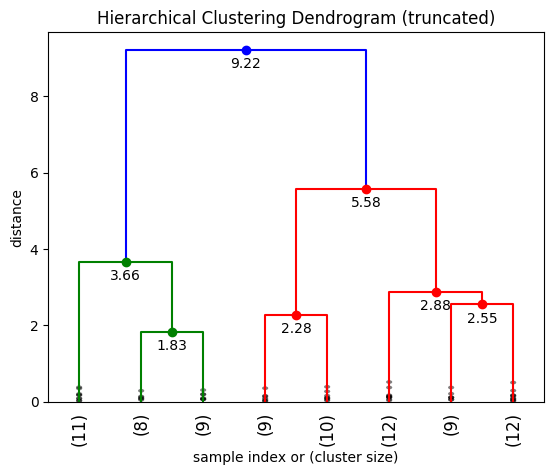

In [126]:
Z = linkage(X, 'ward')
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=8,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=1,  # useful in small plots so annotations don't overlap
)
plt.show()

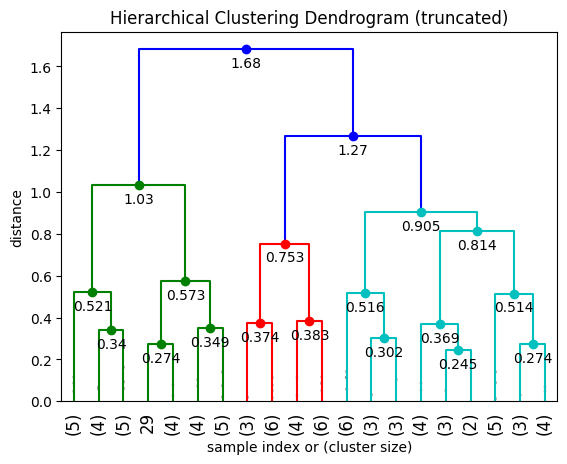

In [79]:
Z = linkage(X, 'average')
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=20,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=0.2,  # useful in small plots so annotations don't overlap
)
plt.show()

In [394]:
#levels[::-1]

## Sklearn examples

In [ ]:
linkage = "ward"
clustering = AgglomerativeClustering(n_clusters=2, linkage=linkage).fit(X)
lab = clustering.labels_
colors = { 0:"seagreen", 1:'beige', 2:'yellow', 3:'grey', 
           4:'pink', 5:'navy', 6:'orange', 7:'purple', 8:'salmon', 9:'olive', 10:'brown',
           11:'tan', 12: 'plum', 13:'red', 14:'lightblue', 15:"khaki", 16:"gainsboro", 17:"peachpuff"}
plt.figure(figsize=(14,4))
for i in range(len(X)):
    plt.scatter(X[i,0], X[i,1], color=colors[lab[i]], s=300)
plt.show()

# CURE

The clustering algorithm starts with each input point as a separate cluster, and at each successive step merges the closest pair of clusters. In order to compute the distance between a pair of clusters, for each cluster, $c$ representative points are stored. These are determined by first choosing $c$ well scattered points within the cluster, and then shrinking them toward the mean of the cluster by a fraction $\alpha$. The distance between two clusters is then the distance between the closest pair of representative points - one belonging to each of the two clusters. Thus, only the representative points of a cluster are used to compute its distance from other clusters.

The $c$ representative points attempt to capture the physical shape and geometry of the cluster. Furthermore, shrinking the scattered points toward the mean by a factor $c$ gets rid of surface abnormalities and mitigates the effects of outliers. The reason for this is that outliers typically will be further away from the cluster center, and as a result, the shrinking would cause outliers to move more toward the center while the remaining representative points would experience minimal shifts. The larger movements in the outliers would thus reduce their ability to cause the wrong clusters to be merged. The parameter $\alpha$ can also be used to control the shapes of clusters. A smaller value of $\alpha$ shrinks the scattered points very little and thus favors elongated clusters. On the other hand, with larger values of $\alpha$, the scattered points get located closer to the mean, and clusters tend to be more compact.

The HEAP update phase is not optimized in this version of the algorithm, see the paper to know more about optimization details.


See the OPTIMIZATION paragraph for the optimized version for larger datasets.


In this version, outliers are not taken into consideration; see the paper to know how to handle outliers.

## Functions

In [81]:
def point_plot_mod2(X, a, reps, level_txt, level2_txt=None, plot_lines=False, 
                    par_index=None, u=None, u_cl=None, initial_ind=None, last_reps=None,
                    not_sampled=None, not_sampled_ind=None, n_rep_fin=None):
    
    if par_index is not None:
        diz = dict(zip(par_index,[i for i in range(len(par_index))]))
    
    fig, ax = plt.subplots(figsize=(14,6))
    
    plt.scatter(X[:,0], X[:,1], s=300, color="lime", edgecolor="black")
    
    a = a.dropna(1, how="all")
    
    colors = { 0:"seagreen", 1:'beige', 2:'yellow', 3:'grey', 
               4:'pink', 5:'turquoise', 6:'orange', 7:'purple', 8:'yellowgreen', 9:'olive', 10:'brown',
               11:'tan', 12: 'plum', 13:'rosybrown', 14:'lightblue', 15:"khaki", 16:"gainsboro", 17:"peachpuff"}
    
    len_ind = [len(i.split("-")) for i in list(a.index)]
    start = np.min([i for i in range(len(len_ind)) if len_ind[i]>1])
    
    for ind,i in enumerate(range(start,len(a))):
        point = a.iloc[i].name.replace("(","").replace(")","").split("-")
        if par_index is not None:
            for j in range(len(point)):
                plt.scatter(X[diz[point[j]],0], X[diz[point[j]],1], s=350, color=colors[ind%18])
        else:
            point = [int(i) for i in point]
            for j in range(len(point)):
                plt.scatter(X[point[j],0], X[point[j],1], s=350, color=colors[ind%18])
                
    point = a.iloc[-1].name.replace("(","").replace(")","").split("-")
    #print(point)
    if par_index is not None:
        point = [diz[point[i]] for i in range(len(point))]
        com = X[point].mean(axis=0)
    else:
        point = [int(i) for i in point]
        com = X[point].mean(axis=0)
    
    plt.scatter(com[0], com[1], s=400, color="r", marker="X", edgecolor="black")
    
    #print(len(reps))
    x_reps = [i[0] for i in reps]
    y_reps = [i[1] for i in reps]
    plt.scatter(x_reps, y_reps, s=360, color="r", edgecolor="black")
    
    if par_index is not None:
        rect_min = X[point].min(axis=0)
        rect_diff = X[point].max(axis=0)-rect_min
    else:
        rect_min = X[point].min(axis=0)
        rect_diff = X[point].max(axis=0)-rect_min
        
    xmin, xmax, ymin, ymax = plt.axis()
    xwidth = xmax - xmin
    ywidth = ymax - ymin
    
    xx_rect = xwidth*0.015 #.05
    #yy_rect = ywidth #.1
    yy_rect = xx_rect*2
    
    if plot_lines == True:
        plt.axvline(rect_min[0], color="black")
        plt.axvline(rect_diff[0]+rect_min[0], color="black")
        plt.axhline(rect_min[1], color="black")
        plt.axhline(rect_diff[1]+rect_min[1], color="black")
    
    
    plt.gcf().gca().add_patch(Rectangle((rect_min[0] - xx_rect, rect_min[1] - xx_rect), 
                                        rect_diff[0]+yy_rect, rect_diff[1]+yy_rect, fill=True, 
                                        color=colors[ind%14], alpha=0.1, linewidth=3, 
                                        ec="black"))
    plt.gcf().gca().add_patch(Rectangle((rect_min[0] - xx_rect, rect_min[1] - xx_rect), 
                                        rect_diff[0]+yy_rect, rect_diff[1]+yy_rect, fill=None, 
                                        color='r', alpha=1, linewidth=3 
                                        ))
    
    xw1 = xwidth*0.009
    yw1 = ywidth*0.015
    
    xw2 = xwidth*0.005
    yw2 = ywidth*0.01
    
    xw3 = xwidth*0.01
    yw3 = ywidth*0.01

    if initial_ind is not None:
        for i, txt in enumerate(initial_ind):
            if len(str(txt))==2:
                ax.annotate(txt, (X[:,0][i]-xw1, X[:,1][i]-yw1), fontsize=12, size=12)
            elif len(str(txt))==1:
                ax.annotate(txt, (X[:,0][i]-xw2, X[:,1][i]-yw2), fontsize=12, size=12)
            else:
                ax.annotate(txt, (X[:,0][i]-xw3, X[:,1][i]-yw3), fontsize=9, size=9)
        
    else:
        for i, txt in enumerate([i for i in range(len(X))]):
            if len(str(txt))==2:
                ax.annotate(txt, (X[:,0][i]-xw1, X[:,1][i]-yw1), fontsize=12, size=12)
            elif len(str(txt))==1:
                ax.annotate(txt, (X[:,0][i]-xw2, X[:,1][i]-yw2), fontsize=12, size=12)
            else:
                ax.annotate(txt, (X[:,0][i]-xw3, X[:,1][i]-yw3), fontsize=9, size=9)
            
    ax.annotate("min_dist: " + str(round(level_txt,5)), (xmax*0.75,ymax*0.9), fontsize=12, size=12)
    
    if level2_txt is not None:
        ax.annotate("dist_incr: " + str(round(level2_txt,5)), (xmax*0.75,ymax*0.8), fontsize=12, size=12)
    
    ax.annotate("n° clust: " + str(len(a)), (xmax*0.75,ymax*0.7), fontsize=12, size=12)
    
    plt.show()
    
    
    if last_reps is not None:
        
        fig, ax = plt.subplots(figsize=(14,6))
    
        plt.scatter(X[:,0], X[:,1], s=300, color="lime", edgecolor="black")
        
        coms = []
        for ind,i in enumerate(range(start,len(a))):
            point = a.iloc[i].name.replace("(","").replace(")","").split("-")
            for j in range(len(point)):
                plt.scatter(X[diz[point[j]],0], X[diz[point[j]],1], s=350, color=colors[ind%18])
            point = [diz[point[i]] for i in range(len(point))]
            coms.append(X[point].mean(axis=0))
        
        
        colors_reps = ["red", "crimson","indianred", "lightcoral", "salmon", "darksalmon", "firebrick"]
        
        flat_reps = [item for sublist in list(last_reps.values()) for item in sublist]
                
        for i in range(len(last_reps)):
            x = [list(last_reps.values())[i][j][0] for j in range(n_rep_fin)]
            y = [list(last_reps.values())[i][j][1] for j in range(n_rep_fin)]
            
            plt.scatter(x, y, s=400, color=colors_reps[i], edgecolor="black")
            plt.scatter(coms[i][0], coms[i][1], s=400, color=colors_reps[i], marker="X", edgecolor="black")
            
            for num in range(n_rep_fin):
                plt.gcf().gca().add_artist(plt.Circle((x[num], y[num]), xwidth*0.03, 
                                                      color=colors_reps[i], fill=False, linewidth=3, alpha=0.7))
            
            plt.scatter(not_sampled[:,0], not_sampled[:,1], s=400, color="lime", edgecolor="black")
        
        for ind in range(len(not_sampled)):
            dist_int = []
            for el in flat_reps:
                dist_int.append(dist1(not_sampled[ind], el))
            ind_min = np.argmin(dist_int)
            
            plt.arrow(not_sampled[ind][0],not_sampled[ind][1], 
                      flat_reps[ind_min][0]-not_sampled[ind][0], flat_reps[ind_min][1]-not_sampled[ind][1],
                      length_includes_head=True, head_width=0.03, head_length=0.05)
            
        for i, txt in enumerate(initial_ind):
            if len(str(txt))==2:
                ax.annotate(txt, (X[:,0][i]-xw1, X[:,1][i]-yw1), fontsize=12, size=12)
            elif len(str(txt))==1:
                ax.annotate(txt, (X[:,0][i]-xw2, X[:,1][i]-yw2), fontsize=12, size=12)
            else:
                ax.annotate(txt, (X[:,0][i]-xw3, X[:,1][i]-yw3), fontsize=9, size=9)
        
        if not_sampled_ind is not None:
            for i, txt in enumerate(not_sampled_ind):
                if len(str(txt))==2:
                    ax.annotate(txt, (not_sampled[:,0][i]-xw1, not_sampled[:,1][i]-yw1), fontsize=12, size=12)
                elif len(str(txt))==1:
                    ax.annotate(txt, (not_sampled[:,0][i]-xw2, not_sampled[:,1][i]-yw2), fontsize=12, size=12)
                else:
                    ax.annotate(txt, (not_sampled[:,0][i]-xw3, not_sampled[:,1][i]-yw3), fontsize=9, size=9)
            
        plt.show()
    
    if par_index is not None:

        diz["(" + u + ")" + "-" + "(" + u_cl + ")"] = len(diz)
        list_keys_diz = list(diz.keys())
        #diz = dict(zip(list_new,[i for i in range(len(list_new))]))
        
        return list_keys_diz      

In [38]:
def dist_clust_cure(rep_u, rep_v):
    rep_u = np.array(rep_u)
    rep_v = np.array(rep_v)
    distances = []
    for i in rep_u:
        for j in rep_v:
            #print(i,j)
            distances.append(dist1(i,j))
    return np.min(distances)

In [39]:
def update_mat_cure(mat,i,j, rep_new, name):
    
    a1 = mat.loc[i]
    b1 = mat.loc[j]
    
    key_lists = list(rep_new.keys())
    #print(len(key_lists))
    
    vec = []
    for i in range(len(mat)):
        #print(i)
        vec.append(dist_clust_cure(rep_new[name], rep_new[key_lists[i]]))
        

    mat.loc["("+a1.name+")"+"-"+"("+b1.name+")",:] = vec
    mat["("+a1.name+")"+"-"+"("+b1.name+")"] = vec + [np.inf]
    
    mat = mat.drop([a1.name,b1.name], 0)
    mat = mat.drop([a1.name,b1.name], 1)
    
    return mat    

In [40]:
def sel_rep(clusters, name, c, alpha):
    
    if len(clusters[name]) <= c:
        
        others = clusters[name]
        com = np.mean(clusters[name], axis=0)
        
        for i in range(len(others)):
            others[i] = others[i] + alpha*(com - others[i])
        
        return others

    else:

        others = []
        indexes = []

        points = clusters[name]
        com = np.mean(points, axis=0)

        distances_com = {i : dist1(points[i], com) for i in range(len(points))}
        index = max(distances_com, key=distances_com.get)

        indexes.append(index)
        others.append(np.array(points[index])) # first point    

        for step in range(min(c-1,len(points)-1)):
            partial_distances = {str(i): [] for i in range(len(points))}
            for i in range(len(points)):
                if i not in indexes:
                    for k in range(len(others)):
                        #print(partial_distances)
                        partial_distances[str(i)].append([dist1(points[i], np.array(others[k]))])
            partial_distances = dict((k, [np.sum(v)]) for k,v in partial_distances.items())
            index2 = max(partial_distances, key=partial_distances.get)
            indexes.append(int(index2))
            others.append(points[int(index2)])

        for i in range(len(others)):
            others[i] = others[i] + alpha*(com - others[i])

        return others

In [41]:
def sel_rep_fast(prec_reps, clusters, name, c, alpha):
    
    com = np.mean(clusters[name], axis=0)
    
    if len(prec_reps) <= c:
        
        others = prec_reps
        for i in range(len(others)):
            others[i] = others[i] + alpha*(com - others[i])
        
        return others

    else:

        others = []
        indexes = []

        points = prec_reps
        
        distances_com = {i : dist1(points[i], com) for i in range(len(points))}
        index = max(distances_com, key=distances_com.get)

        indexes.append(index)
        others.append(np.array(points[index])) # first point    

        for step in range(min(c-1,len(points)-1)):
            partial_distances = {str(i): [] for i in range(len(points))}
            for i in range(len(points)):
                if i not in indexes:
                    for k in range(len(others)):
                        #print(partial_distances)
                        partial_distances[str(i)].append([dist1(points[i], np.array(others[k]))])
            partial_distances = dict((k, [np.sum(v)]) for k,v in partial_distances.items())
            index2 = max(partial_distances, key=partial_distances.get)
            indexes.append(int(index2))
            others.append(points[int(index2)])

        for i in range(len(others)):
            others[i] = others[i] + alpha*(com - others[i])

        return others

## Algorithm

In [86]:
def cure(X, k, c=3, alpha=0.1, plotting=True, preprocessed_data = None, 
         partial_index = None, n_rep_finalclust=None, not_sampled=None, not_sampled_ind=None):
    
    if preprocessed_data is None:
        l = [[i,i] for i in range(len(X))]
        flat_list = [item for sublist in l for item in sublist]
        col = [str(el)+"x" if i%2==0 else str(el)+"y" for i, el in enumerate(flat_list)]
        
        if partial_index is not None:
            a = pd.DataFrame(index = partial_index, columns = col)
        else:
            a = pd.DataFrame(index = [str(i) for i in range(len(X))], columns = col)
        
        a["0x"]=X.T[0]
        a["0y"]=X.T[1]
        
        b = a.dropna(axis=1, how="all")

        # initial clusters
        #clusters = {str(i):X[i] for i in range(len(X))}
        if partial_index is not None:
            clusters = dict(zip(partial_index, X))
        else:
            clusters = {str(i): np.array(X[i]) for i in range(len(X))}

        # build Xdist
        X_dist1 = dist_mat_gen(b)

        #initialize representatives
        if partial_index is not None:
            rep = {partial_index[i]: [X[int(i)]] for i in range(len(X))}
        else:
            rep = {str(i): [X[i]] for i in range(len(X))}

        #just as placeholder for while loop
        heap = [1]*len(X_dist1)

        # store minimum distances between clusters for each iteration
        levels = []
    
    else:

        clusters = preprocessed_data[0]
        rep = preprocessed_data[1]
        a = preprocessed_data[2]
        X_dist1 = preprocessed_data[3]
        heap = [1]*len(X_dist1)
        levels = []
    
    if partial_index is not None:
        initial_index = deepcopy(partial_index)
        
    while len(heap) > k:
        #print(len(heap))

        list_argmin = list(X_dist1.apply(lambda x: np.argmin(x)).values)
        list_min = list(X_dist1.min(axis=0).values)
        heap = dict(zip(list(X_dist1.index), list_min))
        heap = dict(OrderedDict(sorted(heap.items(), key=lambda kv: kv[1])))
        closest = dict(zip(list(X_dist1.index), list_argmin))

        #get minimum key and delete it
        u = min(heap, key=heap.get)
        levels.append(heap[u])
        del heap[u]
        u_cl = closest[u]
        del closest[u]

        #form the new cluster
        if (np.array(clusters[u]).shape == (2,)) and (np.array(clusters[u_cl]).shape == (2,)):
            w = [clusters[u],clusters[u_cl]]
        elif (np.array(clusters[u]).shape != (2,)) and (np.array(clusters[u_cl]).shape == (2,)):
            clusters[u].append(clusters[u_cl])
            w = clusters[u]
        elif (np.array(clusters[u]).shape == (2,)) and (np.array(clusters[u_cl]).shape != (2,)):
            clusters[u_cl].append(clusters[u])
            w = clusters[u_cl]
        else:
            w = clusters[u] + clusters[u_cl]

        #delete old cluster
        del clusters[u]
        del clusters[u_cl]

        name = "(" + u + ")" + "-" + "(" + u_cl + ")"
        clusters[name] = w

        #update representatives
        rep[name] = sel_rep_fast(rep[u] + rep[u_cl], clusters, name, c, alpha)
        
        #update distance matrix
        X_dist1 = update_mat_cure(X_dist1, u, u_cl, rep, name)

        del rep[u]
        del rep[u_cl]
        
        if plotting == True:
            
            dim1 = int(a.loc[u].notna().sum())
        
            a.loc["("+u+")"+"-"+"("+u_cl+")",:] = a.loc[u].fillna(0) + a.loc[u_cl].shift(dim1, fill_value=0)
            a = a.drop(u,0)
            a = a.drop(u_cl,0)

            if partial_index is not None:
                
                if (len(heap) == k) and (not_sampled is not None) and (not_sampled_ind is not None):
                    #print(rep)
                    final_reps = {list(rep.keys())[i] : random.sample(list(rep.values())[i], n_rep_finalclust) for i in range(len(rep))}
                    partial_index = point_plot_mod2(X=X, a=a, reps=rep[name], 
                                                level_txt=levels[-1], par_index=partial_index, 
                                                u=u, u_cl=u_cl, initial_ind = initial_index, 
                                                last_reps= final_reps, not_sampled=not_sampled,
                                                not_sampled_ind = not_sampled_ind, n_rep_fin=n_rep_finalclust)
                else:
                    partial_index = point_plot_mod2(X=X, a=a, reps=rep[name], 
                                                level_txt=levels[-1], par_index=partial_index, 
                                                u=u, u_cl=u_cl, initial_ind = initial_index) 
            else:
                point_plot_mod2(X, a, rep[name], levels[-1])
                
    return (clusters, rep, a)

## Plot

In [65]:
#clusters, rep, mat_a= cure(X,2, c=4, alpha=0.6)

In [63]:
#clusters, rep, mat_a = cure(varied,3, c=4, alpha=0.5, plotting=True)

In [69]:
#clusters, rep, mat_a = cure(varied,3, c=7, alpha=0.85, plotting=False)

In [68]:
def plot_results_cure(clust, k):
    cl_list = []
    for num_clust in range(k):
        cl_list.append(np.array(clust[list(clust.keys())[num_clust]]))
        try:
            plt.scatter(cl_list[-1][:,0], cl_list[-1][:,1])
        except:
            plt.scatter(cl_list[-1][0], cl_list[-1][1])
    plt.show()

#plot_results_cure(clusters, 3)

## Tests

In [121]:
l = [[i,i] for i in range(len(X))]
flat_list = [item for sublist in l for item in sublist]
col = [str(el)+"x" if i%2==0 else str(el)+"y" for i, el in enumerate(flat_list)]
a = pd.DataFrame(index=[str(i) for i in range(len(X))], columns=col)
a["0x"]=X.T[0]
a["0y"]=X.T[1]
b = a.dropna(axis=1, how="all")

# initial clusters
even_num = [i for i in range(2,len(X)+1) if i%2==0]
#clusters = {str(i):X[i] for i in range(len(X))}
clusters = {str(i):np.array(X[i]) for i in range(len(X))} #list instead of np.array

# build heap
X_dist1 = dist_mat_gen(b)

#initialize representatives
rep = {str(i): [X[i]] for i in range(len(X))}

#just as placeholder for while loop
heap = [1]*len(X_dist1)

In [122]:
list_argmin = list(X_dist1.apply(lambda x: np.argmin(x)).values)
list_min = list(X_dist1.min(axis=0).values)
heap = dict(zip(list(X_dist1.index), list_min))
heap = dict(OrderedDict(sorted(heap.items(), key=lambda kv: kv[1])))
closest = dict(zip(list(X_dist1.index), list_argmin))

In [123]:
#heap
pd.DataFrame(heap.values(), index=heap.keys()).head()

,0
38,0.012074
58,0.012074
40,0.017342
63,0.017342
51,0.019027


In [124]:
u = min(heap, key=heap.get)
print(u)
print(heap[u])
zzz = heap[u]
del heap[u]
u_cl = closest[u]
del closest[u]
print(u_cl)

38
0.012074170168487662
58


In [1844]:
#zzz

In [125]:
if (np.array(clusters[u]).shape == (2,)) and (np.array(clusters[u_cl]).shape == (2,)):
    w = [clusters[u],clusters[u_cl]]
elif (np.array(clusters[u]).shape != (2,)) and (np.array(clusters[u_cl]).shape == (2,)):
    clusters[u].append(clusters[u_cl])
    w = clusters[u]
elif (np.array(clusters[u]).shape == (2,)) and (np.array(clusters[u_cl]).shape != (2,)):
    clusters[u_cl].append(clusters[u])
    w = clusters[u_cl]
else:
    w = clusters[u] + clusters[u_cl]
print(w)

[array([0.08080641, 0.29285479]), array([0.07722699, 0.28132338])]


In [126]:
del clusters[u]
del clusters[u_cl]

name = "(" + u + ")" + "-" + "(" + u_cl + ")"
clusters[name] = w
print(name)
    
clean_u = u.replace("(","").replace(")","").split("-")
clean_ucl = u_cl.replace("(","").replace(")","").split("-")
print(clean_u)
print(clean_ucl)

(38)-(58)
['38']
['58']


In [1847]:
#rep

In [127]:
rep[u] + rep[u_cl]

[array([0.08080641, 0.29285479]), array([0.07722699, 0.28132338])]

In [128]:
#rep[u_cl]

In [130]:
rep[name] = sel_rep_fast(rep[u] + rep[u_cl], clusters, name, c=3, alpha=0.5)
print(rep[name])

[array([0.07991156, 0.28997194]), array([0.07812184, 0.28420623])]


In [1851]:
#rep[name]

In [131]:
#X_dist1 = dist_mat_gen(b)
X_dist1 = update_mat_cure(X_dist1, u, u_cl, rep, name)
del rep[u]
del rep[u_cl]

In [132]:
X_dist1.tail(3)

,0,1,2,3,4,5,6,7,8,9,...,71,72,73,74,75,76,77,78,79,(38)-(58)
78,1.126888,1.094488,0.613283,1.127293,0.306036,0.976255,0.341137,1.715581,0.786730,0.205327,...,0.533581,0.991059,0.641317,1.687315,0.406259,1.500166,1.746344,inf,1.105982,0.631952
79,1.394129,0.663887,1.406828,1.451051,1.265912,1.472510,0.999541,1.300147,0.869618,1.135055,...,1.391860,0.696990,1.396099,1.526665,1.266430,0.701008,1.474039,1.105982,inf,0.619322
(38)-(58),0.859847,0.985945,0.785773,0.901636,0.687278,0.876730,0.724423,1.692823,0.914150,0.758222,...,0.778128,0.937679,0.773285,1.804309,0.662529,1.237347,1.805606,0.631952,0.619322,inf


In [133]:
dim1 = int(a.loc[u].notna().sum())

a.loc["("+u+")"+"-"+"("+u_cl+")",:] = \
        a.loc[u].fillna(0) + a.loc[u_cl].shift(dim1, fill_value=0)

In [134]:
a = a.drop(u,0)
a = a.drop(u_cl,0)

In [1810]:
#a

## Optimization for Large Datasets

### Choosing sampling size 

In [44]:
# u_min: size of the smallest cluster u, f: percentage of cluster points (0 <= f <= 1), N: total size, s: sample size, d: 0 <= d <= 1
# the probability that the sample contains less than f*|u| points of cluster u is less than d

# if one uses as |u| the minimum cluster size we are interested in, the result is the minimum sample size that guarantees that for k clusters
# the probability of selecting fewer than f*|u| points from any one of the clusters u is less than k*d.

def Chernoff_Bounds(u_min, f, N, d, k):
    
    l = np.log(1/d)
    res = f*N + N/u_min * l + N/u_min * np.sqrt(l**2 + 2*f*u_min*l)
    print("If the sample size is {0}, the probability of selecting fewer than {1} points from".format(math.ceil(res),round(f*u_min)) \
          + " any one of the clusters is less than {0}".format(k*d))
    
    return res
    

In [45]:
Chernoff_Bounds(u_min=500, f=0.5, N=20000, k=2, d=0.05) 

If the sample size is 11673, the probability of selecting fewer than 250 points from any one of the clusters is less than 0.1


11672.551055396723

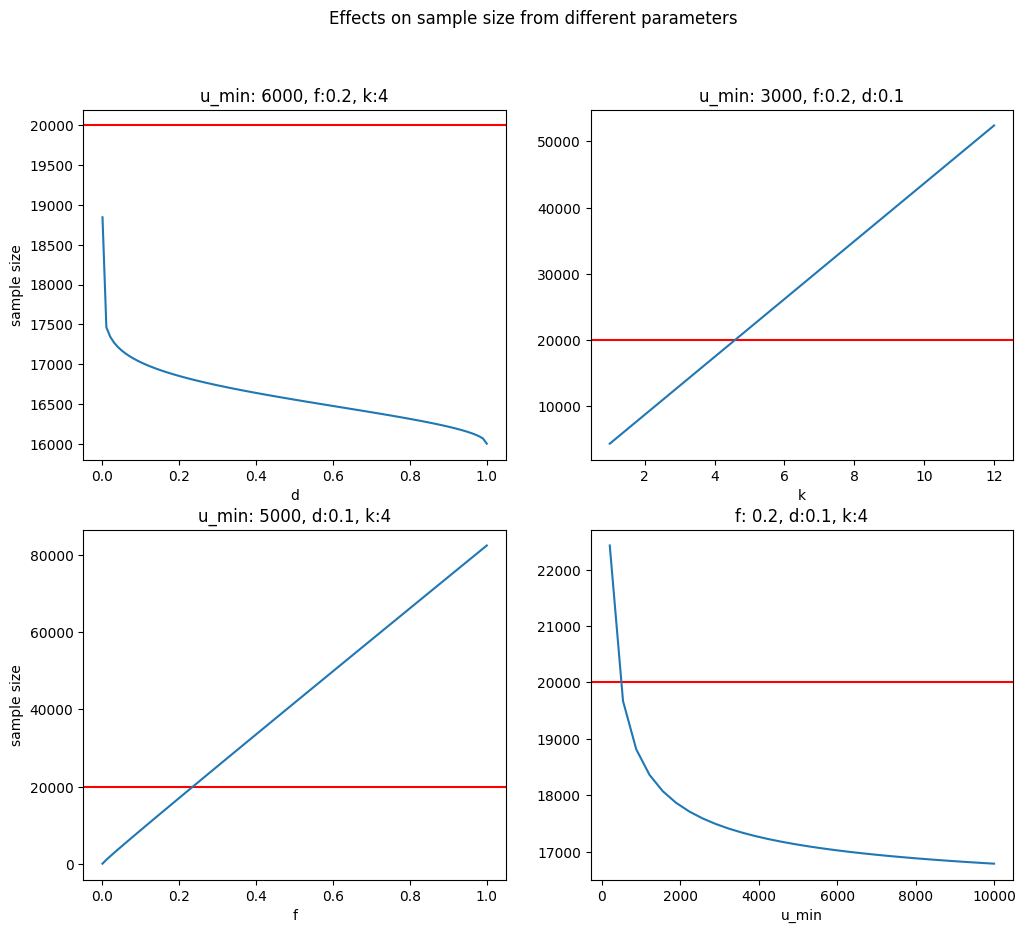

In [46]:
plt.figure(figsize=(12,10))
plt.suptitle("Effects on sample size from different parameters")

ax0 = plt.subplot(2, 2, 1)
#plt.plot(d, k*res)
u_size=6000 
f=0.20 
N=20000
k=4
d = np.linspace(0.0000001,1,100)
ax0.set_title("u_min: {0}, f:{1}, k:{2}".format(u_size, f, k))
res = k*(f*N + N/u_size * np.log(1/d) + N/u_size * np.sqrt(np.log(1/d)**2 + 2*f*u_size*np.log(1/d)))
plt.axhline(N, color="r")
plt.plot(d, res)
plt.xlabel("d")
plt.ylabel("sample size")

ax1 = plt.subplot(2, 2, 2)

u_size=3000 
f=0.2 
N=20000
d=0.1
k = [1,2,3,4,5,6,7,8,9,10,11,12]
ax1.set_title("u_min: {0}, f:{1}, d:{2}".format(u_size, f, d))
res = [k[i]*(f*N + N/u_size * np.log(1/d) + N/u_size * np.sqrt(np.log(1/d)**2 + 2*f*u_size*np.log(1/d))) for i in range(len(k))]
plt.axhline(N, color="r")
plt.plot(k, res)
plt.xlabel("k")

ax2 = plt.subplot(2, 2, 3)

u_size=5000 
f= np.linspace(0.00001,1,100)
N=20000
d=0.1
k = 4
ax2.set_title("u_min: {0}, d:{1}, k:{2}".format(u_size, d, k))
res = k*(f*N + N/u_size * np.log(1/d) + N/u_size * np.sqrt(np.log(1/d)**2 + 2*f*u_size*np.log(1/d)))
plt.axhline(N, color="r")
plt.plot(f, res)
plt.xlabel("f")
plt.ylabel("sample size")

ax3 = plt.subplot(2, 2, 4)

u_size= np.linspace(200,10000,30)
f= 0.2
N=20000
d=0.1
k = 4
ax3.set_title("f: {0}, d:{1}, k:{2}".format(f, d, k))
res = k*(f*N + N/u_size * np.log(1/d) + N/u_size * np.sqrt(np.log(1/d)**2 + 2*f*u_size*np.log(1/d)))
plt.axhline(N, color="r")
plt.plot(u_size, res)
plt.xlabel("u_min")

plt.show()

### Partitioning

In [47]:
def dist_mat_gen_cure(dictionary):
    
    #even_num = [i for i in range(2,len(X)+1) if i%2==0]
    D = pd.DataFrame()
    ind = list(dictionary.keys())
    k = 0
    for i in ind:
        for j in ind[k:]:
            if i!=j:
                
                a = dictionary[i]
                b = dictionary[j]

                D.loc[i,j] = dist_clust_cure(a, b)
                D.loc[j,i] = D.loc[i,j]
            else:
                
                D.loc[i,j] = np.inf 
            
        k += 1
    
    D = D.fillna(np.inf)
    
    return D

In [48]:
def cure_sample_part(X, k, c=3, alpha=0.3, u_min=None, f=0.4, d=0.01, p=None, q=None, n_rep_finalclust=None):
    
    if u_min is None:
        u_min = round(len(X)/k)
    
    if n_rep_finalclust is None:
        n_rep_finalclust=c
    
    l = [[i,i] for i in range(len(X))]
    flat_list = [item for sublist in l for item in sublist]
    col = [str(el)+"x" if i%2==0 else str(el)+"y" for i, el in enumerate(flat_list)]
    a = pd.DataFrame(index=[str(i) for i in range(len(X))], columns=col)
    a["0x"]=X.T[0]
    a["0y"]=X.T[1]
    b = a.dropna(axis=1, how="all")
    
    n = math.ceil(Chernoff_Bounds(u_min=u_min, f=f, N=len(X), k=k, d=d)) 
    b_sampled = b.sample(n, random_state=42)
    b_notsampled = b.loc[[str(i) for i in range(len(b)) if str(i) not in b_sampled.index], :]
    
    if (p is None) and (q is None):
        
        def g(x):
            res = (x[1]-1)/(x[0]*x[1]) + 1/(x[1]**2)
            return res

        results = {}
        for i in range(2,15):
            for j in range(2,15):
                results[(i,j)] = g([i,j])
        p, q = max(results, key=results.get)
        print("p: ", p)
        print("q: ", q)
    
    if (n/(p*q)) < 2*k:
        print("n/pq is less than 2k, results could be wrong")

    z = round(n/p)
    lin_sp = np.linspace(0,n,p+1, dtype="int")
    #lin_sp
    b_partitions = []
    for num_p in range(p):
        try:
            b_partitions.append(b_sampled.iloc[lin_sp[num_p]:lin_sp[num_p+1]])
        except:
            b_partitions.append(b_sampled.iloc[lin_sp[num_p]:])
            
    k_prov = round(n/(p*q))
    
    partial_clust1 = []
    partial_rep1 = []
    partial_a1 = []

    for i in range(p):
        print("\n")
        print(i)
        clusters, rep, mat_a = cure(b_partitions[i].values, k=k_prov, c=c, alpha=alpha, partial_index=b_partitions[i].index)
        partial_clust1.append(clusters)
        partial_rep1.append(rep)
        partial_a1.append(mat_a)
    
    #merging all data into single components
    #clusters
    clust_tot = {}
    for d in partial_clust1:
        clust_tot.update(d)
    #representatives
    rep_tot = {}
    for d in partial_rep1:
        rep_tot.update(d)
    #mat a
    diz = {i:len(b_partitions[i]) for i in range(p)}
    num_freq = Counter(diz.values()).most_common(1)[0][0]
    bad_ind = [list(diz.keys())[i] for i in range(len(diz)) if diz[i] != num_freq]

    for ind in bad_ind:
        partial_a1[ind]["{0}x".format(diz[ind])] = [np.nan]*k_prov
        partial_a1[ind]["{0}y".format(diz[ind])] = [np.nan]*k_prov

    for i in range(len(partial_a1)-1):
        if i == 0:
            a_tot = partial_a1[i].append(partial_a1[i+1]) 
        else:
            a_tot = a_tot.append(partial_a1[i+1])
    # mat Xdist
    X_dist_tot = dist_mat_gen_cure(rep_tot)

    # final_clustering
    prep_data = [clust_tot, rep_tot, a_tot, X_dist_tot]
    clusters, rep, mat_a = cure(b_sampled.values, k=k, c=c, alpha=alpha, preprocessed_data=prep_data, 
                                partial_index=b_sampled.index, n_rep_finalclust=n_rep_finalclust, not_sampled=b_notsampled.values,
                                not_sampled_ind=b_notsampled.index)

In [85]:
#cure_sample_part(varied,c=5, alpha=0.3, k=3)

### Tests again

In [484]:
l = [[i,i] for i in range(len(X))]
flat_list = [item for sublist in l for item in sublist]
col = [str(el)+"x" if i%2==0 else str(el)+"y" for i, el in enumerate(flat_list)]
a = pd.DataFrame(index=[str(i) for i in range(len(X))], columns=col)
a["0x"]=X.T[0]
a["0y"]=X.T[1]
b = a.dropna(axis=1, how="all")

In [485]:
n = math.ceil(Chernoff_Bounds(u_min=40, f=0.4, N=80, k=2, d=0.01)) 
b_sampled = b.sample(n, random_state=42)
b_notsampled = b.loc[[str(i) for i in range(len(b)) if str(i) not in b_sampled.index], :]

If the sample size is 68, the probability of selecting fewer than 16 points from any one of the clusters is less than 0.02


In [467]:
def g(x):
    res = (x[1]-1)/(x[0]*x[1]) + 1/(x[1]**2)
    return res

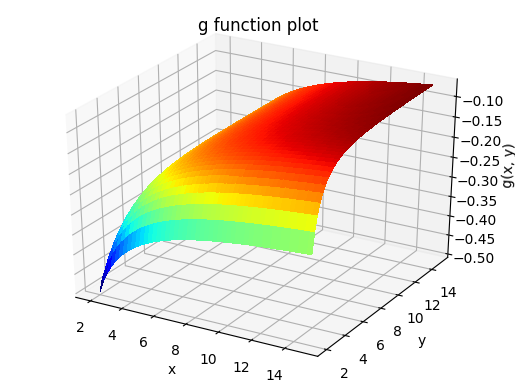

In [460]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(xg, yg, g([xg, yg]), rstride=1, cstride=1,
                       cmap=plt.cm.jet, linewidth=0, antialiased=False)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('g(x, y)')
ax.set_title('g function plot')
plt.show()

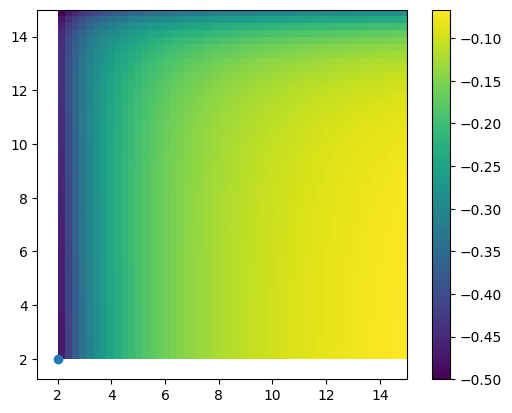

In [459]:
plt.figure()
n=80
k=2
cons = ({'type': 'ineq', 'fun': lambda x:  n/(x[0]*x[1])-2*k})
x_max = scipy.optimize.minimize(g, x0 = [3,3], bounds=[(2,None), (2,None)], constraints=cons)

x = np.linspace(2, 15)
y = np.linspace(2, 15)
xg, yg = np.meshgrid(x, y)
# Show the function in 2D
plt.imshow(g([xg, yg]), extent=[2, 15, 2, 15])
plt.colorbar()
# And the minimum that we've found:
plt.scatter(x_max.x[0], x_max.x[1])

plt.show()

In [464]:
results = {}
for i in range(2,15):
    for j in range(2,15):
        results[(i,j)] = abs(g([i,j]))
p, q = max(results, key=results.get)

In [466]:
q

2

In [486]:
p = 2
q = 2
z = round(n/p)
lin_sp = np.linspace(0,n,p+1, dtype="int")
lin_sp

array([ 0, 34, 68])

In [487]:
b_partitions = []
for num_p in range(p):
    try:
        b_partitions.append(b_sampled.iloc[lin_sp[num_p]:lin_sp[num_p+1]])
    except:
        b_partitions.append(b_sampled.iloc[lin_sp[num_p]:])

In [488]:
k_prov = round(n/(p*q))

In [423]:
#(n/(p*q))

In [ ]:
partial_clust1 = []
partial_rep1 = []
partial_a1 = []

for i in range(p):
    #print(i)
    clusters, rep, mat_a = cure(b_partitions[i].values, k=k_prov, c=3, alpha=0.3, partial_index=b_partitions[i].index)
    partial_clust1.append(clusters)
    partial_rep1.append(rep)
    partial_a1.append(mat_a)

In [ ]:
#merging all data into single components
#clusters
clust_tot = {}
for d in partial_clust1:
    clust_tot.update(d)
#representatives
rep_tot = {}
for d in partial_rep1:
    rep_tot.update(d)
#mat a
diz = {i:len(b_partitions[i]) for i in range(p)}
num_freq = Counter(diz.values()).most_common(1)[0][0]
bad_ind = [list(diz.keys())[i] for i in range(len(diz)) if diz[i] != num_freq]

for ind in bad_ind:
    partial_a1[ind]["{0}x".format(diz[ind])] = [np.nan]*k_prov
    partial_a1[ind]["{0}y".format(diz[ind])] = [np.nan]*k_prov

for i in range(len(partial_a1)-1):
    if i == 0:
        a_tot = partial_a1[i].append(partial_a1[i+1]) 
    else:
        a_tot = a_tot.append(partial_a1[i+1])
# mat Xdist
X_dist_tot = dist_mat_gen_cure(rep_tot)

# final_clustering
prep_data = [clust_tot, rep_tot, a_tot, X_dist_tot]
clusters, rep, mat_a = cure(b_sampled.values, k=2, c=3, alpha=0.2, preprocessed_data=prep_data, 
                            partial_index=b_sampled.index, n_rep_finalclust=3, not_sampled=b_notsampled.values,
                            not_sampled_ind=b_notsampled.index)

# BIRCH

Look at paper and PP presentation: Balanced Iterative Reducing and Clustering using Hierarchies.
It consists of a preprocessing phase that stores the input data into a CF-tree, whose leaves are then analyzed by a clustering algorithm (not necessarily hierarchical) to derive the clustering of the data. It is useful for large datasets, and it runs in O(n) time-complexity, but the order of input data as well as the non-spherical shape of clusters may compromise its effectiveness.

In order to plot all the steps, the following has been modified:

Pyclustering cluster/birch.py:
    - many "prints" have been inserted
    - plot_tree_fin and plot_birch_leaves have been inserted into "insert_data" method of the birch class
    - return_tree method has been added
    

## Functions

In [6]:
def plot_birch_leaves(tree, data, limit_plot = None):
    fig, ax = plt.subplots(figsize=(14,6))
    
    if limit_plot is not None:
        plt.scatter(np.array(data)[:limit_plot,0], np.array(data)[:limit_plot,1], s=300, color="white", edgecolor="black")
    else:
        plt.scatter(np.array(data)[:,0], np.array(data)[:,1], s=300, color="white", edgecolor="black")
    
    for i,el in enumerate(tree.get_level_nodes(tree.height-1)):
        colors = { 0:"seagreen", 1:'beige', 2:'yellow', 3:'grey', 
                   4:'pink', 5:'turquoise', 6:'orange', 7:'purple', 8:'yellowgreen', 9:'olive', 10:'brown',
                   11:'tan', 12: 'plum', 13:'rosybrown', 14:'lightblue', 15:"khaki", 16:"gainsboro", 17:"peachpuff"}
        #entriez = []
        for entry in el.entries:
            if entry.number_points == 1:
                plt.scatter(entry.linear_sum[0], entry.linear_sum[1], color=colors[i%17], s=300, edgecolor="black")
            else:
                plt.scatter(entry.get_centroid()[0], entry.get_centroid()[1], color=colors[i%17], marker="X", s=200)
                plt.annotate(entry.number_points, (entry.get_centroid()[0], entry.get_centroid()[1]), fontsize=18)


    xmin, xmax, ymin, ymax = plt.axis()
    xwidth = xmax - xmin
    ywidth = ymax - ymin

    xw1 = xwidth*0.01
    yw1 = ywidth*0.01

    xw2 = xwidth*0.005
    yw2 = ywidth*0.01
    
    xw3 = xwidth*0.01
    yw3 = ywidth*0.01

    if limit_plot is None:
        for i, txt in enumerate(range(len(data))):
            if len(str(txt))==2:
                ax.annotate(txt, (np.array(data)[:,0][i]-xw1, np.array(data)[:,1][i]-yw1), fontsize=12, size=12)
            elif len(str(txt))==1:
                ax.annotate(txt, (np.array(data)[:,0][i]-xw2, np.array(data)[:,1][i]-yw2), fontsize=12, size=12)
            else:
                ax.annotate(txt, (np.array(data)[:,0][i]-xw3, np.array(data)[:,1][i]-yw3), fontsize=9, size=9)
    else:
        for i, txt in enumerate(range(len(np.array(data[:limit_plot])))):
            if len(str(txt))==2:
                ax.annotate(txt, (np.array(data)[:,0][i]-xw1, np.array(data)[:,1][i]-yw1), fontsize=12, size=12)
            elif len(str(txt))==1:
                ax.annotate(txt, (np.array(data)[:,0][i]-xw2, np.array(data)[:,1][i]-yw2), fontsize=12, size=12)
            else:
                ax.annotate(txt, (np.array(data)[:,0][i]-xw3, np.array(data)[:,1][i]-yw3), fontsize=9, size=9) 


    #plt.gca().set_aspect('equal', adjustable='box')#print(el.entries)
    plt.show()

In [7]:
def plot_tree(tree):
    
    height = tree.height
    if height !=3:
        print("Tree height must be 3, in this case it is {0}".format(height))
        return
    #L = tree.threshold
    #B = tree.branch_factor
    colors = { 0:"seagreen", 1:'beige', 2:'yellow', 3:'grey', 
                   4:'pink', 5:'turquoise', 6:'orange', 7:'purple', 8:'yellowgreen', 9:'olive', 10:'brown',
                   11:'tan', 12: 'plum', 13:'rosybrown', 14:'lightblue', 15:"khaki", 16:"gainsboro", 17:"peachpuff"}

    num_points_root = tree.root.feature.number_points
    num_root_successors = len(tree.root.successors)

    def feat_create(level):
        features1 = []
        features1_num = []
        for el in level:
            f = el.feature
            features1.append(f)
            features1_num.append(f.number_points)

        return (features1, features1_num)

    (features1, features1_num) = feat_create(tree.root.successors)

    features2 = []
    entries = []
    len_single_entries = []
    for ind in range(num_root_successors):
        features2.append(feat_create(tree.root.successors[ind].successors))
        for el in tree.root.successors[ind].successors:
            entries.append(el.entries)
            len_single_entries.append([record.number_points for record in el.entries])

    len_tot2 = [len(features2[i][1]) for i in range(len(features2))]
    features2_num = [features2[i][1] for i in range(len(features2))]
    features2_num = [item for sublist in features2_num for item in sublist]
    len_single_entries_flat = [item for sublist in len_single_entries for item in sublist]
    num_entries = [len(x) for x in entries]
    num_leaves = len(num_entries)
    
    prov = "A B C D E F G H I J K L M N O P Q R S T U V W X Y Z a b c d e f g h i j k l m n o p q r s t u v w x y z".split(" ")
    lett = []
    for i in range(len(prov)):
        for j in range(len(prov)):
            lett.append(prov[i]+prov[j])
    

    dot = graphviz.Digraph(comment='Clustering')
    #root
    dot.node(lett[0], str(num_points_root))
    
    for q1 in range(1,num_root_successors+1):
        dot.node(lett[q1], str(features1_num[q1-1]))

    for q2 in range(1,num_leaves+1):
        dot.node(lett[num_root_successors+q2], str(num_entries[q2-1]))

    for q3 in range(1, len(len_single_entries)+1):
        dot.node(lett[num_root_successors+num_leaves+q3], str(len_single_entries[q3-1]), 
                color=colors[(q3-1)%17], style="filled")

    a = 0
    b = 0
    for i in range(num_root_successors):
        dot.edge(lett[a],lett[i+1])

    b = num_root_successors
    a += 1
    for num in len_tot2:
        for j in range(num):
            dot.edge(lett[a],lett[b+j+1])
        a += 1
        b += j+1

    for k in range(num_leaves):
        dot.edge(lett[a],lett[b+k+1])
        a += 1
    #dot.edges(['BD','BE','BF','CG','CH','CI', 'CJ'])
    #dot.edges([lett[1]+lett[3], lett[1]+lett[4], lett[1]+lett[5], lett[2]+lett[6], lett[2]+lett[7], lett[2]+lett[8], lett[2]+lett[9]])

    #dot.edges(['DK','EL','FM','GN','HO','IP','JQ'])

    #dot.edges(['DK','DL','EM','FN','GO','HP','HQ','IR','IS','IT','IU','IV','JW'])
    #dot.edges([lett[3]+lett[10], lett[3]+lett[11], lett[4]+lett[12], lett[5]+lett[13], lett[6]+lett[14], lett[7]+lett[15], 
    #           lett[7]+lett[16], lett[8]+lett[17], lett[8]+lett[18], lett[8]+lett[19], lett[8]+lett[20], lett[8]+lett[21], lett[9]+lett[22]])

    #dot.edge('B', 'L', constraint='false')
    graph = graphviz.Source(dot)#.view()
    
    display(graph)
    #dot.render('./Clustering.gv', view=True)

In [8]:
def plot_tree_fin(tree, info=False):

    height = tree.height
    
    if info == True:
        print("Tree height is {0}".format(height))
        print("Number of nodes: {0}".format(tree.amount_nodes))
        print("Number of leaves: {0}".format(len(tree.leafes)))
        print("Number of entries: {0}".format(tree.amount_entries))
    
    if tree.amount_nodes > 2704:
        print("Too many nodes, limit is 2704")
        
        return

    colors = { 0:"seagreen", 1:'beige', 2:'yellow', 3:'grey', 
               4:'pink', 5:'turquoise', 6:'orange', 7:'purple', 8:'yellowgreen', 9:'olive', 10:'brown',
               11:'tan', 12: 'plum', 13:'rosybrown', 14:'lightblue', 15:"khaki", 16:"gainsboro", 17:"peachpuff"}

    def feat_create(level_nodes):
        features = []
        features_num = []
        succ_num = []
        for el in level_nodes:
            f = el.feature
            features.append(f)
            features_num.append(f.number_points)
            try:
                succ_num.append(len(el.successors))
            except:
                pass

        return (features, features_num, succ_num)

    feat = []
    feat_num = []
    succ_num = []
    for lev in range(height):
        (f1, f2, s1) = feat_create(tree.get_level_nodes(lev))
        feat.append(f1)
        feat_num.append(f2)
        succ_num.append(s1)

    single_entries = []
    for z in tree.get_level_nodes(height-1):
        sing_ent_prov = []
        for single_entry in z.entries:
            sing_ent_prov.append(single_entry.number_points)
        single_entries.append(sing_ent_prov)

    prov = "A B C D E F G H I J K L M N O P Q R S T U V W X Y Z a b c d e f g h i j k l m n o p q r s t u v w x y z".split(" ")
    lett = []
    for i in range(len(prov)):
        for j in range(len(prov)):
            lett.append(prov[i]+prov[j])
    

    dot = graphviz.Digraph(comment='Clustering')
    #root
    dot.node(lett[0], str(feat_num[0][0]))

    placeholder = 0
    for level in range(1, height+1):
        if level != height:
            for q in range(1,len(feat_num[level])+1):
                dot.node(lett[placeholder+q], str(feat_num[level][q-1]))
            placeholder += q
        else:
            for q in range(1,len(single_entries)+1):
                dot.node(lett[placeholder+q], str(single_entries[q-1]),
                         color=colors[(q-1)%17], style="filled")


    a = 0
    b = 0
    for level in range(0, height):
        for num_succs in succ_num[level]:
            for el in range(num_succs):
                dot.edge(lett[a],lett[b+el+1])
            a += 1
            b += el+1

    for i in range(len(single_entries)):
        dot.edge(lett[a], lett[b+i+1] )
        a += 1

    graph = graphviz.Source(dot)#.view()

    display(graph)

## Plots

In [16]:
X = make_blobs(n_samples=40,
                             cluster_std=[2.5, 2.5, 2.5],
                             random_state=42)[0]
#plt.scatter(X[:,0], X[:,1])
#plt.show()

In [10]:
#brc = Birch(threshold=1.5, branching_factor=10)
#brc.fit(X)

In [13]:
birch_instance = birch(X.tolist(), 3, initial_diameter=10, max_node_entries=4,
                      type_measurement=measurement_type.CENTROID_EUCLIDEAN_DISTANCE)

birch_instance.process()

In [274]:
#plot_tree(birch_instance.return_tree())

In [39]:
#plot_tree_fin(birch_instance.return_tree(), info=True)

In [12]:
#plot_birch_leaves(birch_instance.return_tree(), X)

In [34]:
#birch_instance.return_tree().show_feature_destibution()

In [33]:
clusters = birch_instance.get_clusters()
# Visualize allocated clusters
visualizer = cluster_visualizer()
visualizer.append_clusters(clusters, X.tolist())
#visualizer.show()

# PAM

## Pseudocode

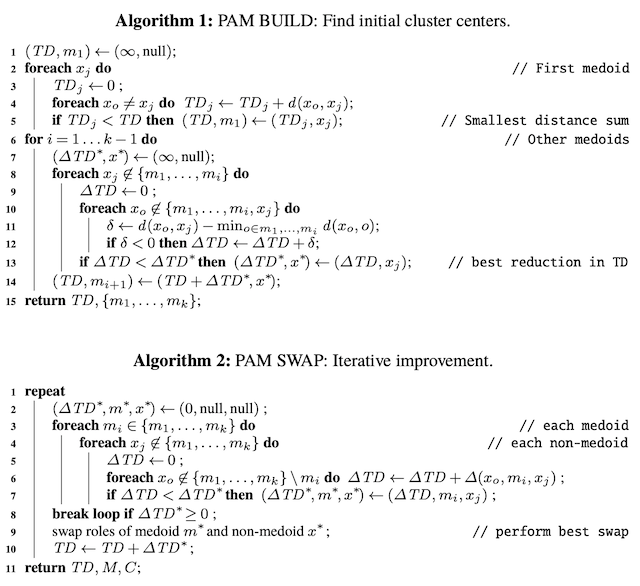

## Algorithm

In [59]:
#SachinKalsi GITHUB
#https://github.com/SachinKalsi/kmedoids/blob/master/KMedoids.py
from scipy.sparse import csr_matrix

class KMedoids:
    def __init__(self, n_cluster=2, max_iter=10, tol=0.1, start_prob=0.8, end_prob=0.99, random_state=42):
        '''Kmedoids constructor called'''
        if start_prob < 0 or start_prob >= 1 or end_prob < 0 or end_prob >= 1 or start_prob > end_prob:
            raise ValueError('Invalid input')
        self.n_cluster = n_cluster
        self.max_iter = max_iter
        self.tol = tol
        self.start_prob = start_prob
        self.end_prob = end_prob
        
        self.medoids = [] #empty medois
        self.clusters = {} #empty clusters
        self.tol_reached = float('inf')
        self.current_distance = 0
        
        self.__data = None
        self.__is_csr = None
        self.__rows = 0
        self.__columns = 0
        self.cluster_distances = {}
        
        self.__random_state = random_state
        
    def fit(self, data):
        print("fitting")
        self.__data = data
        self.__set_data_type()     
        self.__start_algo()
        return self
    
    def __start_algo(self):
        print("starting algo")
        self.__initialize_medoids() #choosing initial medoids
        #computing clusters and cluster_distances
        self.clusters, self.cluster_distances = self.__calculate_clusters(self.medoids) 
        # print cluster and cluster_distances
        print("clusters: ")
        pprint.PrettyPrinter(indent=2, compact=True).pprint(self.clusters)
        print("clusters_distances: ", self.cluster_distances)
        plot_pam(self.__data, self.clusters)
        
        self.__update_clusters()
    
    def __update_clusters(self):
        for i in range(self.max_iter): #to stop if convergence isn't reached whithin max_iter iterations
            print("\n")
            print("iteration n°: ", i)
            #compute distance obtained by swapping medoids in the clusters
            cluster_dist_with_new_medoids = self.__swap_and_recalculate_clusters() 
            #if the new sum of cluster_distances is smaller than the old one
            if self.__is_new_cluster_dist_small(cluster_dist_with_new_medoids) == True:
                print("new is smaller")
                #compute clusters and cluster_distance with new medoids
                self.clusters, self.cluster_distances = self.__calculate_clusters(self.medoids)
                print("clusters: ")
                pprint.PrettyPrinter(indent=2, compact=True).pprint(self.clusters)
                plot_pam(self.__data, self.clusters)
                #print("clusters_distances: ", self.cluster_distances)
            else:
                #if the sum of cluster_distances doesn't improve, terminate the algorithm
                print("termination")
                break

    def __is_new_cluster_dist_small(self, cluster_dist_with_new_medoids):
        """returns True if the new sum of cluster_distances is smaller than the previous one, and updates the medoids, else returns False"""
        #compute the existing sum of cluster_distances
        existance_dist = self.calculate_distance_of_clusters()
        print("present dist: ", existance_dist)
        #computes the new sum of cluster_distances
        new_dist = self.calculate_distance_of_clusters(cluster_dist_with_new_medoids)
        print("new dist: ", new_dist)
        
        #if it is better, substitute the old medoids with the new ones and return True, else return False
        if existance_dist > new_dist and (existance_dist - new_dist) > self.tol:
            self.medoids = cluster_dist_with_new_medoids.keys()
            return True
        
        return False
    
    def calculate_distance_of_clusters(self, cluster_dist=None):
        """if no argument is provided, just sum the distances of the existing cluster_distances, else sum the distances of the 
        input cluster_distances """
        if cluster_dist == None:
            cluster_dist = self.cluster_distances
        dist = 0
        for medoid in cluster_dist.keys():
            dist += cluster_dist[medoid]
        return dist
        
    def __swap_and_recalculate_clusters(self):
        # http://www.math.le.ac.uk/people/ag153/homepage/KmeansKmedoids/Kmeans_Kmedoids.html
        """returns dictionary of new cluster_distances obtained by swapping medoids in each cluster"""
        print("swap and recompute")
        cluster_dist = {}
        for medoid in self.medoids: #for each medoid
            is_shortest_medoid_found = False
            for data_index in self.clusters[medoid]: #for each point in the current medoid's cluster
                if data_index != medoid: #exclude the medoid itself
                    # create a list of the elements of the cluster
                    cluster_list = list(self.clusters[medoid])
                    # make the current point the temporary medoid
                    cluster_list[self.clusters[medoid].index(data_index)] = medoid
                    # compute new cluster distance obtained by swapping the medoid
                    new_distance = self.calculate_inter_cluster_distance(data_index, cluster_list)
                    if new_distance < self.cluster_distances[medoid]: #if this new distance is smaller than the previous one
                        print("new better medoid: ", data_index)
                        cluster_dist[data_index] = new_distance
                        is_shortest_medoid_found = True
                        break #exit for loop for this medoid, since a better one has been found
            #if no better medoid has been found, keep the current one
            if is_shortest_medoid_found == False:
                print("no better medoids found, keep: ", medoid)
                cluster_dist[medoid] = self.cluster_distances[medoid]
        print("cluster_dist: ", cluster_dist)
        return cluster_dist
    
    def calculate_inter_cluster_distance(self, medoid, cluster_list):
        """computes the average distance of points in a cluster from their medoid"""
        distance = 0
        for data_index in cluster_list:
            distance += self.__get_distance(medoid, data_index)
        return distance/len(cluster_list)
        
    def __calculate_clusters(self, medoids):
        """returns the clusters and the relative distances (average distance of each element of the cluster from the medoid)"""
        clusters = {} #it will be of the form {medoid0: [elements of cluster0], medoid1: [elements of cluster1], ...}
        cluster_distances = {}
        #initialize empty clusters and cluster_distances
        for medoid in medoids:
            clusters[medoid] = []
            cluster_distances[medoid] = 0
            
        for row in range(self.__rows): #for every row of input data
            #compute nearest medoid and relative distance from row
            nearest_medoid, nearest_distance = self.__get_shortest_distance_to_medoid(row, medoids)
            #add this distance to the distances relative to the nearest_medoid cluster
            cluster_distances[nearest_medoid] += nearest_distance
            #add the row to the nearest_medoid cluster
            clusters[nearest_medoid].append(row)
        
        # divide each cluster_distance for the number of element in its corresponding cluster, to obtain the average distance
        for medoid in medoids:
            cluster_distances[medoid] /= len(clusters[medoid])
        return clusters, cluster_distances
        
        
    def __get_shortest_distance_to_medoid(self, row_index, medoids):
        """returns closest medoid and relative distance from the input row (point)"""
        min_distance = float('inf')
        current_medoid = None
        
        for medoid in medoids:
            current_distance = self.__get_distance(medoid, row_index) #compute distance from input row to medoid
            if current_distance < min_distance: #if it happens to be shorter than all previously computed distances 
                min_distance = current_distance #save it as min_distance
                current_medoid = medoid #choose this medoid as the closest one
        return current_medoid, min_distance

    def __initialize_medoids(self):
        '''Kmeans++ initialisation'''
        print("initializing medoids with kmeans++")
        random.seed(self.__random_state)
        
        self.medoids.append(random.randint(0,self.__rows-1)) #choosing a random row from data
        
        while len(self.medoids) != self.n_cluster: #until the number of medoids reaches the number of clusters
            self.medoids.append(self.__find_distant_medoid()) #choose as next medoid the most distant from the previously chosen ones
    
    def __find_distant_medoid(self):
        """returns a row corresponding to a point which is considerably distant from its closest medoid"""
        distances = []
        indices = []
        for row in range(self.__rows): #for every row in data
            indices.append(row)
            distances.append(self.__get_shortest_distance_to_medoid(row,self.medoids)[1]) #shortest distance from row to its closest medoid
        distances_index = np.argsort(distances) #the sorted indices of the distances
        choosen_dist = self.__select_distant_medoid(distances_index) #the index corresponding to the distance chosen 
        return indices[choosen_dist] #row corresponding to the chosen distance
    
    def __select_distant_medoid(self, distances_index):
        """returns a random index of the distances_index between start and end"""
        start_index = round(self.start_prob*len(distances_index)) #normally 0.8*len(dist)
        end_index = round(self.end_prob*(len(distances_index)-1)) #normally 0.99*len(dist)
        #returns a random index corresponding to a row which is distant from its closest medoid, but not necessarily the row with the
        # maximum distance from its medoid
        return distances_index[random.randint(start_index, end_index)]

                           
    def __get_distance(self, x1, x2):
        """computes euclidean distance, with an initial transformation based on input data"""
        a = self.__data[x1].toarray() if self.__is_csr == True else np.array(self.__data[x1])
        b = self.__data[x2].toarray() if self.__is_csr == True else np.array(self.__data[x2])
        return np.linalg.norm(a-b)
    
    def __set_data_type(self):
        '''to check whether the given input is of type "list" or "csr" '''
        print("setting data type")
        if isinstance(self.__data,csr_matrix):
            self.__is_csr = True
            self.__rows = self.__data.shape[0]
            self.__columns = self.__data.shape[1]
        elif isinstance(self.__data,list):
            self.__is_csr = False
            self.__rows = len(self.__data)
            self.__columns = len(self.__data[0])
        else:
            raise ValueError('Invalid input')

In [488]:
def plot_pam(data, cl):
    
    fig,ax = plt.subplots(figsize=(14,6))
    plt.scatter(np.array(data)[:,0], np.array(data)[:,1], s=300, color="white", edgecolor="black")
    colors = { 0:"seagreen", 1:'beige', 2:'yellow', 3:'grey', 
                   4:'pink', 5:'turquoise', 6:'orange', 7:'purple', 8:'yellowgreen', 9:'olive', 10:'brown',
                   11:'tan', 12: 'plum', 13:'rosybrown', 14:'lightblue', 15:"khaki", 16:"gainsboro", 17:"peachpuff"}

    for i,el in enumerate(list(cl.values())):
        plt.scatter(np.array(data)[el,0], np.array(data)[el,1], s=300, color=colors[i%17], edgecolor="black")

    for i,el in enumerate(list(cl.keys())):
        plt.scatter(np.array(data)[el,0], np.array(data)[el,1], s=500, color="red", marker="X", edgecolor="black")

    xmin, xmax, ymin, ymax = plt.axis()
    xwidth = xmax - xmin
    ywidth = ymax - ymin

    xw1 = xwidth*0.01
    yw1 = ywidth*0.01

    xw2 = xwidth*0.005
    yw2 = ywidth*0.01

    xw3 = xwidth*0.01
    yw3 = ywidth*0.01

    for i, txt in enumerate(range(len(data))):
        if len(str(txt))==2:
            ax.annotate(txt, (np.array(data)[:,0][i]-xw1, np.array(data)[:,1][i]-yw1), fontsize=12, size=12)
        elif len(str(txt))==1:
            ax.annotate(txt, (np.array(data)[:,0][i]-xw2, np.array(data)[:,1][i]-yw2), fontsize=12, size=12)
        else:
            ax.annotate(txt, (np.array(data)[:,0][i]-xw3, np.array(data)[:,1][i]-yw3), fontsize=9, size=9)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

## Plot

fitting
setting data type
starting algo
initializing medoids with kmeans++
clusters: 
{ 20: [2, 8, 10, 11, 12, 14, 18, 20, 27, 29, 31, 32, 34, 37, 38, 48, 49],
  26: [0, 1, 4, 5, 6, 7, 13, 15, 19, 22, 24, 26, 33, 41, 43, 44, 46],
  40: [3, 9, 16, 17, 21, 23, 25, 28, 30, 35, 36, 39, 40, 42, 45, 47]}
clusters_distances:  {40: 3.1435865719112344, 26: 2.843412950014979, 20: 2.4772853388765164}


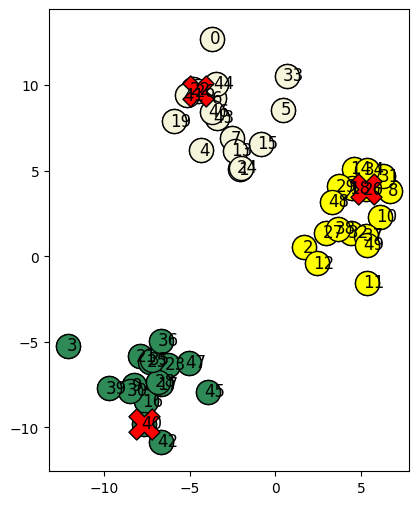



iteration n°:  0
swap and recompute
new better medoid:  9
new better medoid:  6
no better medoids found, keep:  20
cluster_dist:  {9: 2.3341956373419492, 6: 2.5937387373037524, 20: 2.4772853388765164}
present dist:  8.46428486080273
new dist:  7.405219713522218
new is smaller
clusters: 
{ 6: [0, 1, 4, 5, 6, 7, 13, 15, 19, 22, 24, 26, 33, 41, 43, 44, 46],
  9: [3, 9, 16, 17, 21, 23, 25, 28, 30, 35, 36, 39, 40, 42, 45, 47],
  20: [2, 8, 10, 11, 12, 14, 18, 20, 27, 29, 31, 32, 34, 37, 38, 48, 49]}


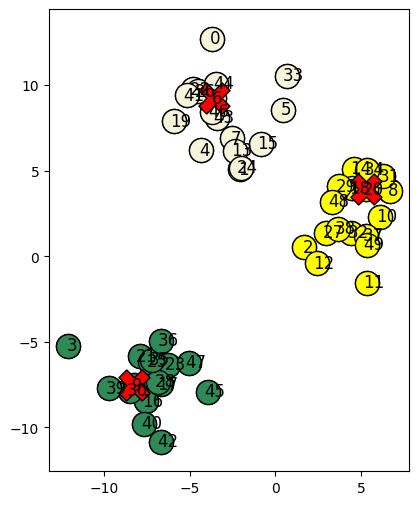



iteration n°:  1
swap and recompute
new better medoid:  17
new better medoid:  43
no better medoids found, keep:  20
cluster_dist:  {17: 2.1813763932003196, 43: 2.4784972179344824, 20: 2.4772853388765164}
present dist:  7.197968073491246
new dist:  7.137158950011319
new is smaller
clusters: 
{ 17: [3, 9, 16, 17, 21, 23, 25, 28, 30, 35, 36, 39, 40, 42, 45, 47],
  20: [2, 8, 10, 11, 12, 14, 18, 20, 27, 29, 31, 32, 34, 37, 38, 48, 49],
  43: [0, 1, 4, 5, 6, 7, 13, 15, 19, 22, 24, 26, 33, 41, 43, 44, 46]}


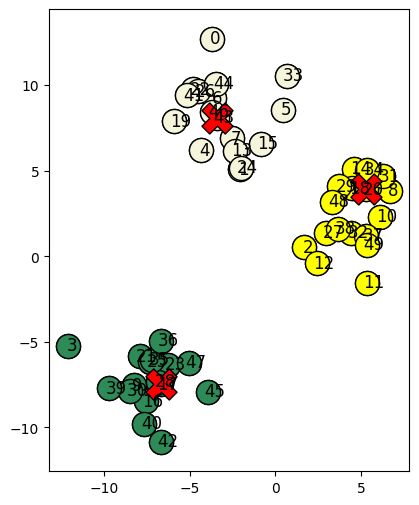



iteration n°:  2
swap and recompute
new better medoid:  28
no better medoids found, keep:  43
no better medoids found, keep:  20
cluster_dist:  {28: 2.0396032286048507, 43: 2.4099903282882127, 20: 2.4772853388765164}
present dist:  6.969949527216823
new dist:  6.92687889576958
new is smaller
clusters: 
{ 20: [2, 8, 10, 11, 12, 14, 18, 20, 27, 29, 31, 32, 34, 37, 38, 48, 49],
  28: [3, 9, 16, 17, 21, 23, 25, 28, 30, 35, 36, 39, 40, 42, 45, 47],
  43: [0, 1, 4, 5, 6, 7, 13, 15, 19, 22, 24, 26, 33, 41, 43, 44, 46]}


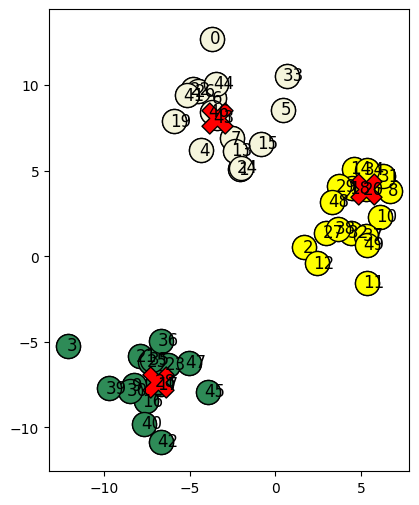



iteration n°:  3
swap and recompute
no better medoids found, keep:  28
no better medoids found, keep:  43
no better medoids found, keep:  20
cluster_dist:  {28: 2.0265749654104934, 43: 2.4099903282882127, 20: 2.4772853388765164}
present dist:  6.9138506325752225
new dist:  6.9138506325752225
termination


In [490]:
X = make_blobs(n_samples=50,
                             cluster_std=[2., 2., 2.],
                             random_state=42)[0]
z = KMedoids(n_cluster=3, tol=0.01)
z.fit(X.tolist())

# CLARA

## Pseudocode

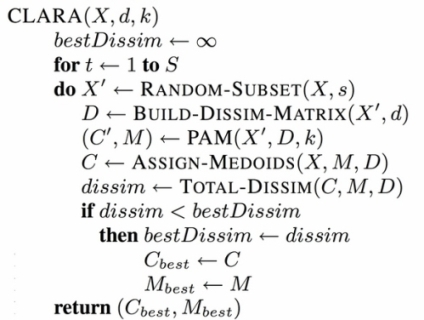

## Algorithm

In [648]:
#akalino GITHUB
#https://github.com/akalino/Clustering/blob/master/clara.py
class ClaraClustering(object):
    """The clara clustering algorithm.
    Basically an iterative guessing version of k-medoids that makes things a lot faster
    for bigger data sets.
    """

    def __init__(self, max_iter=100000):
        """Class initialization.
        :param max_iter: The default number of max iterations
        """
        self.max_iter = max_iter
        self.dist_cache = dict()

    def clara(self, _df, _k, _fn):
        """The main clara clustering iterative algorithm.
        :param _df: Input dataframe.
        :param _k: Number of medoids.
        :param _fn: The distance function to use.
        :return: The minimized cost, the best medoid choices and the final configuration.
        """
        size = len(_df)
        if size > 100000:
            niter = 1000
            runs = 1
        else:
            niter = self.max_iter
            runs = 5

        # initialize min_avg_cost to infinity
        min_avg_cost = np.inf
        best_choices = []
        best_results = {}

        for j in range(runs): #usually 5 times
            print("\n")
            print("run number: ", j)
            #take 40+_k*2 random indexes from input data
            sampling_idx = random.sample([i for i in range(size)], 40+_k*2)
            # take the corresponding rows from input dataframe _df
            prov_dic = { i:sampling_idx[i] for i in range(40+_k*2)}
            print(prov_dic)
            sampling_data = []
            for idx in sampling_idx:
                sampling_data.append(_df.iloc[idx])

            #create the sample dataframe
            sampled_df = pd.DataFrame(sampling_data, index=sampling_idx)
            #print(sampled_df)
            #print(sampled_df)
            #return total cost, medoids and clusters of sampled_df
            pre_cost, pre_choice, pre_medoids = self.k_medoids(sampled_df, _k, _fn, niter)
            plot_pam_mod(sampled_df, pre_medoids, _df)
            print("RESULTS OF K-MEDOIDS")
            print("pre_cost: ", pre_cost)
            print("pre_choice: ", pre_choice)
            print("pre_medoids: ", pre_medoids)
            
            #meds_for_plotting = [prov_dic[i] for i in pre_choice]
            #clusts_for_plotting = []
            #for count in range(_k):
            #    memb_list = list(pre_medoids.values())[count]
            #    clusts_for_plotting.append([prov_dic[i] for i in memb_list])
            
            #pre_medoids_for_plotting = dict(zip(meds_for_plotting, clusts_for_plotting))
            #print("medoids CONVERTED: ", pre_medoids_for_plotting)
            
            #plot_pam_mod(sampled_df, pre_medoids_for_plotting, _df)
            #compute average cost and clusters of whole input dataframe
            tmp_avg_cost, tmp_medoids = self.average_cost(_df, _fn, pre_choice)
            #tmp_avg_cost, tmp_medoids = self.average_cost(_df, _fn, meds_for_plotting)
            print("RESULTS OF WHOLE DATASET EVALUATION")
            print("tmp_avg_cost: ", tmp_avg_cost)
            print("tmp_medoids: ", tmp_medoids)
            #plot_pam_mod(_df, tmp_medoids, _df)
            # if the new cost is lower
            if tmp_avg_cost < min_avg_cost:
                print("new_cost is lower, from {0} to {1}".format(round(min_avg_cost,4), round(tmp_avg_cost,4)))
                min_avg_cost = tmp_avg_cost
                best_choices = list(pre_choice)
                #print("best_choices: ", best_choices)
                best_results = dict(tmp_medoids)
                #print("best_results: ", best_results)
            
            elif tmp_avg_cost == min_avg_cost:
                print("new_cost is equal")
            else:
                print("new_cost is higher")
        
        print("\n")
        print("FINAL RESULT:")
        plot_pam_mod(_df,best_results,_df)

        return min_avg_cost, best_choices, best_results

    def k_medoids(self, _df, _k, _fn, _niter):
        """The original k-medoids algorithm.
        :param _df: Input data frame.
        :param _k: Number of medoids.
        :param _fn: The distance function to use.
        :param _niter: The number of iterations.
        :return: Cost of configuration, the medoids (list) and the clusters (dictionary).
        
        Pseudo-code for the k-medoids algorithm.
        1. Sample k of the n data points as the medoids.
        2. Associate each data point to the closest medoid.
        3. While the cost of the data point space configuration is decreasing.
            1. For each medoid m and each non-medoid point o:
                1. Swap m and o, recompute cost.
                2. If global cost increased, swap back.
        """
        
        #print('K-medoids starting')
        # Do some smarter setting of initial cost configuration
        pc1, medoids_sample = self.cheat_at_sampling(_df, _k, _fn, 17)
        print("initial medoids sample: ", medoids_sample)
        prior_cost, medoids = self.compute_cost(_df, _fn, medoids_sample)
        #print("so called medoids after compute cost: ", medoids)
        #plot_pam_mod(_df, medoids, _df)
        current_cost = prior_cost
        print("current_cost: ", current_cost)
        iter_count = 0
        best_choices = []
        best_results = {}

        #print('Running with {m} iterations'.format(m=_niter))
        while iter_count < _niter:
            for m in medoids:
                #print("m: ", m)
                #print("bc: ", best_choices)
                clust_iter = 0
                for item in medoids[m]:
                    if item != m:
                        idx = medoids_sample.index(m)
                        swap_temp = medoids_sample[idx]
                        medoids_sample[idx] = item
                        tmp_cost, tmp_medoids = self.compute_cost(_df, _fn, medoids_sample, True)
                        
                        if (tmp_cost < current_cost) & (clust_iter < 1):
                            best_choices = list(medoids_sample)
                            #print("change: ", best_choices)
                            best_results = dict(tmp_medoids)
                            current_cost = tmp_cost
                            clust_iter += 1
                        else:
                            #print("else")
                            best_choices = best_choices
                            best_results = best_results
                            current_cost = current_cost
                        medoids_sample[idx] = swap_temp

            iter_count += 1
            if (best_choices == medoids_sample):
                print('Best configuration found! best_choices: ', best_choices)
                break

            if current_cost <= prior_cost:
                if current_cost < prior_cost:
                    print("Better configuration found! curr_cost:{0}, prior_cost:{1}".format(round(current_cost,2), round(prior_cost,2)))
                else:
                    print("Equal cost")
                prior_cost = current_cost
                medoids = best_results
                medoids_sample = best_choices
            
            print("new_medoids: ", best_choices)
        #plot_pam_mod(_df, best_results, _df)
        return current_cost, best_choices, best_results

    def compute_cost(self, _df, _fn, _cur_choice, cache_on=False):
        """A function to compute the configuration cost.
        :param _df: The input dataframe.
        :param _fn: The distance function.
        :param _cur_choice: The current set of medoid choices.
        :param cache_on: Binary flag to turn caching.
        :return: The total configuration cost, the medoids.
        """
        size = len(_df)
        total_cost = 0.0
        medoids = {}
        for idx in _cur_choice:
            medoids[idx] = []
        
        #print(medoids)
        for i in list(_df.index):
            choice = -1
            min_cost = np.inf
            for m in medoids:
                if cache_on:
                    tmp = self.dist_cache.get((m, i), None)

                if not cache_on or tmp is None:
                    if _fn == 'manhattan':
                        tmp = self.manhattan_distance(_df.loc[m], _df.loc[i])
                    elif _fn == 'cosine':
                        tmp = self.cosine_distance(_df.loc[m], _df.loc[i])
                    elif _fn == 'euclidean':
                        tmp = self.euclidean_distance(_df.loc[m], _df.loc[i])
                    elif _fn == 'fast_euclidean':
                        tmp = self.fast_euclidean(_df.loc[m], _df.loc[i])
                    else:
                        print('You need to input a valid distance function (manhattan, cosine, euclidean or fast_euclidean).')

                if cache_on:
                    self.dist_cache[(m, i)] = tmp

                if tmp < min_cost:
                    choice = m
                    min_cost = tmp

            medoids[choice].append(i)
            total_cost += min_cost
        #print("total_cost: ", total_cost)
        return total_cost, medoids

    def average_cost(self, _df, _fn, _cur_choice):
        """A function to compute the average cost.
        :param _df: The input data frame.
        :param _fn: The distance function.
        :param _cur_choice: The current medoid candidates.
        :return: The average cost, the new medoids.
        """
        _tc, _m = self.compute_cost(_df, _fn, _cur_choice)
        avg_cost = _tc / len(_m)
        return avg_cost, _m

    def cheat_at_sampling(self, _df, _k, _fn, _nsamp):
        """A function to cheat at sampling for speed ups.
        :param _df: The input dataframe.
        :param _k: The number of medoids.
        :param _fn: The distance function.
        :param _nsamp: The number of samples.
        :return: The best score, the medoids.
        """
        # this function tries _nsamp different configurations of initial medoids and chooses the one with the lowest cost
        print("cheating at sampling")
        size = len(_df)
        score_holder = []
        medoid_holder = []
        for _ in range(_nsamp): #17 by default
            # take _k random points as medoids_sample
            medoids_sample = random.sample(list(_df.index), _k)
            # compute cost and medoids with this medoids_sample
            prior_cost, medoids = self.compute_cost(_df, _fn, medoids_sample, True)
            # store the cost and medoids
            score_holder.append(prior_cost)
            medoid_holder.append(medoids)
        
        #take the minimum cost and the corresponding medoids
        idx = score_holder.index(min(score_holder))
        ms = medoid_holder[idx].keys()
        return score_holder[idx], list(ms)

    def euclidean_distance(self, v1, v2):
        """Slow function for euclidean distance.
        :param v1: The first vector.
        :param v2: The second vector.
        :return: The euclidean distance between v1 and v2.
        """
        dist = 0
        for a1, a2 in zip(v1, v2):
            dist += abs(a1 - a2)**2
        return dist

    def fast_euclidean(self, v1, v2):
        """Faster function for euclidean distance.
        :param v1: The first vector.
        :param v2: The second vector.
        :return: The euclidean distance between v1 and v2.
        """
        return np.linalg.norm(v1 - v2)

    def manhattan_distance(self, v1, v2):
        """Function for manhattan distance.
        :param v1: The first vector.
        :param v2: The second vector.
        :return: The manhattan distance between v1 and v2.
        """
        dist = 0
        for a1, a2 in zip(v1, v2):
            dist += abs(a1 - a2)
        return dist

    def cosine_distance(self, v1, v2):
        """Function for cosine distance.
        :param v1: The first vector.
        :param v2: The second vector.
        :return: The cosine distance between v1 and v2.
        """
        xx, yy, xy = 0, 0, 0
        for a1, a2 in zip(v1, v2):
            xx += a1*a1
            yy += a2*a2
            xy += a1*a2
        return float(xy) / np.sqrt(xx*yy)

In [650]:
def plot_pam_mod(data, cl, full):
    
    fig,ax = plt.subplots(figsize=(14,6))
    plt.scatter(full.iloc[:,0], full.iloc[:,1], s=300, color="white", edgecolor="white")
    colors = { 0:"seagreen", 1:'beige', 2:'yellow', 3:'grey', 
                   4:'pink', 5:'turquoise', 6:'orange', 7:'purple', 8:'yellowgreen', 9:'olive', 10:'brown',
                   11:'tan', 12: 'plum', 13:'rosybrown', 14:'lightblue', 15:"khaki", 16:"gainsboro", 17:"peachpuff"}

    for i,el in enumerate(list(cl.values())):
        plt.scatter(data.loc[el,0], data.loc[el,1], s=300, color=colors[i%17], edgecolor="black")

    for i,el in enumerate(list(cl.keys())):
        plt.scatter(data.loc[el,0], data.loc[el,1], s=500, color="red", marker="X", edgecolor="black")

    xmin, xmax, ymin, ymax = plt.axis()
    xwidth = xmax - xmin
    ywidth = ymax - ymin

    xw1 = xwidth*0.01
    yw1 = ywidth*0.01

    xw2 = xwidth*0.005
    yw2 = ywidth*0.01

    xw3 = xwidth*0.01
    yw3 = ywidth*0.01

    for i, txt in enumerate(range(len(full))):
        if len(str(txt))==2:
            ax.annotate(txt, (full.iloc[i,0]-xw1, full.iloc[i,1]-yw1), fontsize=12, size=12)
        elif len(str(txt))==1:
            ax.annotate(txt, (full.iloc[i,0]-xw2, full.iloc[i,1]-yw2), fontsize=12, size=12)
        else:
            ax.annotate(txt, (full.iloc[i,0]-xw3, full.iloc[i,1]-yw3), fontsize=9, size=9)
    #plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

## Plots

In [656]:
#beware that input data dimension must be at least 40+2*n_clusters, otherwise it is useless
X = make_blobs(n_samples=250,
                             cluster_std=[1, 4, 1],
                             random_state=42)[0]

In [659]:
#Clara = ClaraClustering()
#final_result = Clara.clara(pd.DataFrame(X), 3, 'fast_euclidean')